## Импорты

In [1]:
import pandas as pd
import numpy as np
import random
import re
import string
import itertools
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["grey", "#e94cdc", "blue", "orange"]) 

random.seed(1)
SEED = 1

In [2]:
#!python -m spacy download en_core_web_lg
#restart runtime after this

In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')

import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# REALEC data

In [76]:
!wget https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/realec_lexical_errors.csv

--2022-05-26 20:53:39--  https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/realec_lexical_errors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3336235 (3.2M) [text/plain]
Saving to: ‘realec_lexical_errors.csv’

realec_lexical_erro 100%[===================>]   3.18M  --.-KB/s    in 0.07s   

2022-05-26 20:53:39 (45.1 MB/s) - ‘realec_lexical_errors.csv’ saved [3336235/3336235]



In [78]:
data = pd.read_csv('realec_lexical_errors.csv')
data.rename(columns={c:c.lower() for c  in data.columns}, inplace=True)
print(f"Number of objects: {data.shape[0]}")
data.sample(5, random_state=SEED)

Number of objects: 17055


,text_name,error_type,error_span,correction,error_sentence
5726,2016_EKu_23_1.txt,"Change, addition, deletion of a part of colloc...",kind,kind of,The line graph illustrates the information abo...
13902,2017_OBy_52_2.txt,Choice of lexical item,illness,diseases,"Overall, human have not reduced illness before..."
4161,2014_TSha_10_1.txt,Choice of lexical item,amount,the percentage,Then we can see that amount of people aged 65 ...
9119,2017_DOv_4_1.txt,Choice of lexical item,reveals,displays,The graph reveals information about proportion...
15656,2019_ABu_224_2.txt,Choice of lexical item,create,develop,"Furthermore, the children who have just starte..."


## Duplicates

In [79]:
len_before = data.shape[0]
data.drop_duplicates(keep='first', inplace=True)
print(f"Dropped {len_before - data.shape[0]} rows, {data.shape[0]} left")

Dropped 120 rows, 16935 left


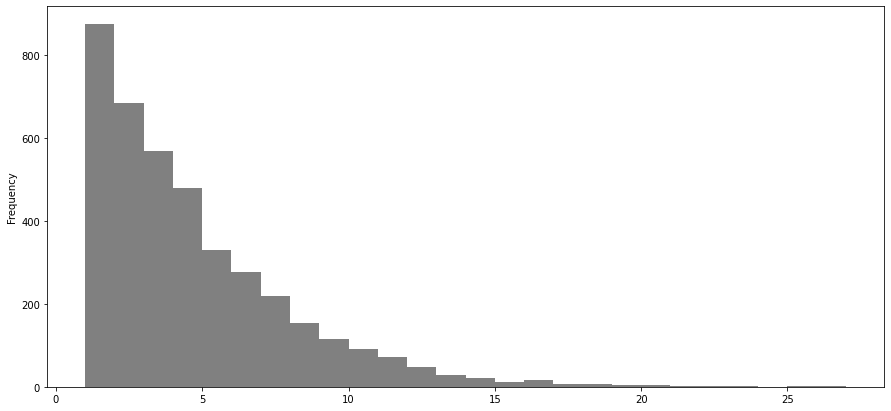

In [80]:
plt.figure(figsize=(15,7))

data_value_counts = data.text_name.value_counts()
data_value_counts.plot(kind='hist', 
                       bins=np.unique(data_value_counts).shape[0])

plt.show()

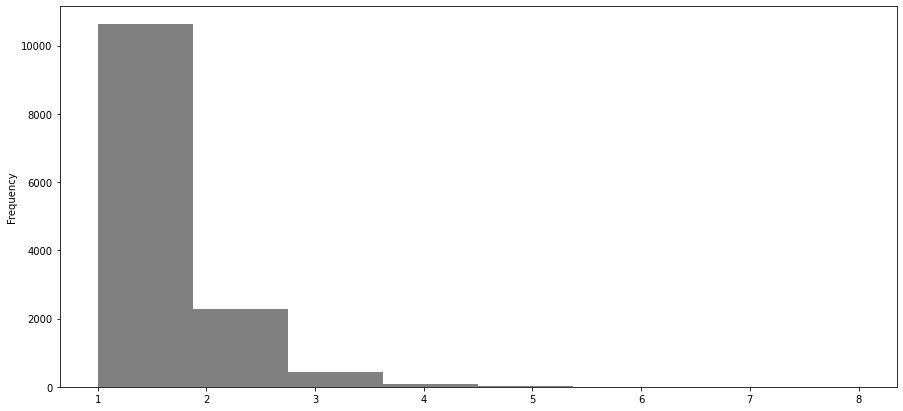

In [81]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['sentence_id'] = le.fit_transform(data['error_sentence'])

plt.figure(figsize=(15,7))
data_value_counts = data['sentence_id'].value_counts()
data_value_counts.plot(kind='hist', 
                       bins=np.unique(data_value_counts).shape[0])

plt.show()

In [82]:
error_spans_per_sentence = data.groupby(['sentence_id', 'error_span']).size()
error_spans_per_sentence = pd.DataFrame(error_spans_per_sentence)
error_spans_per_sentence.sample(2)

,,0
sentence_id,error_span,
2288,was,1
2101,than,1


In [83]:
same_span_several_errors = data.groupby(['sentence_id', 'error_span']).size()
data['same_span_several_errors'] = data[['sentence_id', 'error_span']].apply(lambda x: error_spans_per_sentence.loc[x.values[0]].loc[x.values[1]], axis=1)
data['same_span_several_errors'].value_counts()

1    16741
2      188
3        6
Name: same_span_several_errors, dtype: int64

In [84]:
# В первом случае исправляются разные слова, во втором были разные разметчики
pd.options.display.max_colwidth = 120
data[data['same_span_several_errors'] == 3][['error_span', 'correction', 'error_sentence']].head(15)

,error_span,correction,error_sentence
15425,you,somebody,"That means, if you have money, you can have any service, any product or any thing that you could wish for."
15426,you,he or she,"That means, if you have money, you can have any service, any product or any thing that you could wish for."
15427,you,person,"That means, if you have money, you can have any service, any product or any thing that you could wish for."
16274,shares,percentage,In 1995 the trend of level of obesity among both children levelled off and reached the same shares (nearly 15%).
16275,shares,level,In 1995 the trend of level of obesity among both children levelled off and reached the same shares (nearly 15%).
16276,shares,level,In 1995 the trend of level of obesity among both children levelled off and reached the same shares (nearly 15%).


In [85]:
#в основном разыне разметчики
data[data['same_span_several_errors'] == 2][['error_span', 'correction', 'error_sentence']].head(15)

,error_span,correction,error_sentence
431,are,consisted of,"The number of this people are 21303 and the small group in this sector are people from 56 to 65 years, this fact ill..."
432,are,was made up by,"The number of this people are 21303 and the small group in this sector are people from 56 to 65 years, this fact ill..."
675,amount,the highest proportion,While amount of male firstly has spent 90 percent.
676,amount,proportion,While amount of male firstly has spent 90 percent.
680,Undergraduate diploma,undergraduate diploma holders,Undergraduate diploma was just less half past from all percentage.
681,Undergraduate diploma,the number of undergraduate diploma holders,Undergraduate diploma was just less half past from all percentage.
1098,peck,peak,"The curve heats a peck 25%, and heats a low approximately in 7%."
1099,peck,peak of,"The curve heats a peck 25%, and heats a low approximately in 7%."
1351,is,with,The one which is in London was opened in 1863 and is 394 kilometers while the one in Paris which was opened in 37 ye...
1352,is,has,The one which is in London was opened in 1863 and is 394 kilometers while the one in Paris which was opened in 37 ye...


In [86]:
# в общем я хочу дропнуть эти примеры....
len_before = data.shape[0]

indices_to_drop = data[data['same_span_several_errors'] == 2].index
data.drop(index = indices_to_drop, inplace=True)
print(f"Dropped {len_before - data.shape[0]} rows, {data.shape[0]} left")

Dropped 188 rows, 16747 left


## Target

In [87]:
data1 = data.copy()
data = data1.copy().reset_index(drop=True)
#drop if not latin

In [88]:
data.fillna('', inplace=True)
data.head(5)

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
0,2014_AAl_10_1.txt,Choice of lexical item,incline,increase,"After a stable period, we see a huge incline that would occur in Japan from 2020 to 2040.",253,1
1,2014_AAl_10_1.txt,Choice of lexical item,old,elderly,"USA, however, had bigger part of old people throughout the century, having 10% in 1960 and even 15% in 1980, but the...",12842,1
2,2014_AAl_10_1.txt,Word choice,Sweden chart,The graph for Sweden,"Sweden chart is almost equal to the US one, only big discrepancy is 20% in 2020 in Sweden versus below 15% in the US.",9454,1
3,2014_AAl_10_1.txt,Choice of lexical item,visualize,demonstrates,"Given diagram visualize the proportion of population aged 65 and over in Japan, Sweden and the United States from 19...",3487,1
4,2014_AAl_10_1.txt,Choice of lexical item,part,percentage,"USA, however, had bigger part of old people throughout the century, having 10% in 1960 and even 15% in 1980, but the...",12842,1


#### parentheses

In [89]:
def regex_bool(regexp, text):
  return bool(re.search(regexp, text))

def make_re(text):
  return '[' + '\\'.join(list(text)) + ']'

PARENTHESES = list('()[]{}<>')
PARENTHESES_RE = make_re(PARENTHESES)

indices_where_parentheses = np.where(data['correction'].apply(lambda x: regex_bool(PARENTHESES_RE, x)))[0]
data.iloc[indices_where_parentheses]

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
361,2014_ADe_11_2.txt,Choice of lexical item,enable,let (OR make) their children,It is a parents business to decide when they should enable their children to learn foreign language.,5809,1
1002,2014_ASt_38_1.txt,Choice of lexical item,amount,number (words often confused),"On contrary, the most significant amount of passengers is registered in Paris and Tokyo with 1191 and 1927 million o...",7543,1
3898,2014_MTsy_21_2.txt,Word choice,for money,for (the sake of) making money,"sportsmen motivate a lot of people to go to gym or sections to be healthier and stronger, to be the best, and not do...",13404,1
4837,2014_ZEv_11_1.txt,Word choice,second,next(?),The second two popular countries are Spain and USA which met 9 and 4 million. of tourists from England respectively.,11107,1
6718,2016_MTsy_7_1.txt,Choice of lexical item,such as boys and girls,(boys as well as girls),"It is immediately clear from the graph, that all numbers of children such as boys and girls, declined from 2000 to 2...",5976,1
10516,2017_EGe_98_1.txt,Choice of lexical item,many billion of dollars,much money (in billion dollars),"This bar chat presents the data on how many billion of dollars were spent on print and eBook market in the USA, Germ...",11952,1


In [90]:
def delete_parentheses_in_correction(text):
  return re.sub(' ?\(.*\)', '', text)

def replace_parentheses(text):
  return re.sub(' ?[\(\)] ?', ', ', text)

data['correction'] = data['correction'].apply(lambda x: delete_parentheses_in_correction(x))

data['error_span'] = data['error_span'].apply(lambda x: replace_parentheses(x))

#### symbols

In [91]:
SYMBOLS = ('$^*^~?')
SYMBOLS_RE = make_re(SYMBOLS)

indices_where_symbols = np.where(data['correction'].apply(lambda x: regex_bool(SYMBOLS_RE, x)))[0]
data.iloc[indices_where_symbols].sample(6)

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
996,2014_ASt_35_2.txt,Word choice,picture,?,"Summing up, I am absolutely do not agree that our picture mostly depends on our characteristics from birth.",9436,1
3849,2014_MTsy_17_2.txt,Word choice,many,many/most of them?,"The truth is that a lot of people are too busy or lazy to visit gyms and do sports, so many would prefer to stop smo...",11241,1
5640,2016_EKu_26_2.txt,Word choice,driven,?,"This correlation is driven by our understanding of justice and, therefore, depends on local laws and cultural differ...",11979,1
3959,2014_MTsy_32_1.txt,Word choice,very few,scarce?,People who are older than 60 years are very few.,8395,1
16349,2019_EEr_147_2.txt,Choice of lexical item,raws,???,"To start with, the rows of typical buildings may influence negatively the emotional state of people.",12497,1
5940,2016_JSl_153_1.txt,Choice of lexical item,investment,bn $,The lowest level of investment in developing countries was in 2006 year just round 25 investment.,10448,1


In [92]:
data = data.drop(index = indices_where_symbols).reset_index(drop=True)

#### options

In [93]:
SLASH_RE = '[/\\\]'

indices_where_slash = np.where(data['correction'].apply(lambda x: regex_bool(SLASH_RE, x)))[0]
data.iloc[indices_where_slash].sample(6)

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
7702,2016_ZEv_29_2.txt,Choice of lexical item,spread,widespread/popular/common,"Thus, there is a spread point of view that the number of flights should be controlled by the authorities.",12227,1
1054,2014_ASt_42_2.txt,Word choice,work with brains,to make an intellectual work/ brainwork,"In comparison of first opinion, the second was more power, because a person, who wont work with brains, who will hav...",4799,1
377,2014_ADe_13_2.txt,Choice of lexical item,prepared,thought of / studied,One of the most important things that should be prepared is the foreign language.,7906,1
2590,2014_EPa_8_2.txt,Choice of lexical item,undoubtless,undoubted // doubtless,It is undoubtedly that increasing the number of sports facilities is excellent way to improve public health.,6149,1
3959,2014_MTsy_33_2.txt,Word choice,having,doing/taking up,This tendency will have a good effect on public health if people really understand the pluses of having a sport acti...,12161,1
886,2014_ASt_20_2.txt,Choice of lexical item,qualities,personality/ features,It is believed that our qualities that we have from the moment when we are born play the most significant role in ou...,5853,1


In [94]:
def choose_correction(text):
  if  not ('\\' in text or '/' in text):
    return(text)
  else:
    if '\\' in text:
      options = text.split('\\')
    elif '/' in text:
      options = text.split('/')
    options_lens = [len(o.split(' ')) for o in options]
    if max(options_lens) == 2:
      return options[options_lens.index(2)]
    elif max(options_lens) > 2:
      return ' '.join(options[0].split()+options[1].split()[1:])
    elif len(set(options_lens)) == 1:
      return options[0]
    return ''

data['correction'] = data['correction'].apply(lambda x: choose_correction(x))


#### wrong span

In [95]:
def span_not_in_sent(span, sent):
  return span.lower() not in sent.lower()

incorrect_span_indices = np.where(data[['error_span', 'error_sentence']].apply(lambda x: span_not_in_sent(*x), axis=1))[0]
data.iloc[incorrect_span_indices]

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
11,2014_AAl_11_1.txt,Choice of lexical item,diagramm,the graph,It should be mentioned that diagram shows great increase of the population aged 65 and over in short period of time ...,6269,1
30,2014_AAl_12_2.txt,Choice of lexical item,destlict,deprive,"For instance, if we deprive someone in their right for higher education it can cause the termination of woman develo...",3120,1
39,2014_AAl_13_1.txt,Choice of lexical item,then,than,"However, the economic situation has not always been so brilliant, moreover, it was much worse there than in Europe a...",3834,1
46,2014_AAl_15_1.txt,Choice of lexical item,was continning,remained as such,The graph also shows that the lowest proportion of population aged 65 and over in USA and Sweden was in 1940 while t...,10165,1
65,2014_AAl_18_1.txt,Choice of lexical item,fastly,sharply,After this point the population of elder people in Japan is surely rising up to ten percent in 2030 and fast increas...,300,1
...,...,...,...,...,...,...,...
16692,2019_EEr_34_1.txt,"Change, addition, deletion of a part of collocation",did sport excersises,did exercises,"And we also have a table, which shows how much kids did sport exercise exercise in years 1990 and 2005.",903,1
16707,2019_EEr_77_2.txt,Choice of lexical item,adress,address,"Personally, I believe that both parents and school are equally important and prominent in nurturing children as they...",8457,1
16710,2019_EEr_93_2.txt,Choice of lexical item,posess,have,"As soon as they create an account in social networks, they start to posses a wealth of friends from all over the wor...",1293,1
16726,2019_EEr_99_2.txt,Choice of lexical item,beginnig,origin,"Those two skills are standing very close to each other, which proves the art beginning of the architecture.",12182,1


In [96]:
data = data.drop(index = incorrect_span_indices).reset_index(drop=True)

#### preprocess

In [97]:
#диакритика?
def preprocess_text(text):
  text = text.lower()
  text = text.replace('%', ' percent ')
  text = text.replace('+', ' plus ')
  text = re.sub(r'  +', ' ', text)
  return text

data.fillna('', inplace=True)
data['error_span'] = data['error_span'].apply(lambda x: preprocess_text(x))
data['correction'] = data['correction'].apply(lambda x: preprocess_text(x))
data['error_sentence'] = data['error_sentence'].apply(lambda x: preprocess_text(x))

In [98]:
data['error_correction_pair'] = data[['error_span', 'correction']].apply(lambda x: tuple(x), axis=1)

data_final = data.groupby(['sentence_id']).agg({'error_sentence': lambda x: list(x)[0], 
                                   'error_correction_pair': list}).reset_index()
data_final.head()

,sentence_id,error_sentence,error_correction_pair
0,0,"""agriculture"" in indonesia is in the middle place and the last one is under ""industry"" control.","[(middle, second)]"
1,1,"""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","[(on the first position, in the first place)]"
2,2,(12 million visitors) the second country was spain with 9 million british residents.,"[(residents, holiday-makers)]"
3,3,(in 2020 it became 13 percent ).,"[(became, will be)]"
4,4,"(the destination between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for ...","[(destination, distance)]"


#### Create Target

In [99]:
def strings_intersect(s1, s2):
  return len(set(s1.split(' ')) & set(s2.split(' '))) > 0
def mult_strings_intersect(*args):
  return [(i1, i2) for i1,i2 in itertools.combinations(range(len(args)), 2) if strings_intersect(args[i1], args[i2])]
def errors_intersect(row):
  errors = list(zip(*row))[0]
  check = mult_strings_intersect(*errors)
  if len(check) >0:
    return check
  else:
    return None

def choose_errors(row, intersections):
  intersecting_errors = list(set(sum(intersections, ())))
  not_intersecting = list(set(range(len(row))) - set(intersecting_errors))
  errors = list(zip(*row))[0]
  errors_lens = [len(errors[i]) for i in intersecting_errors]
  chosen_error = intersecting_errors[np.argmax(errors_lens)]
  return [row[i] for i in sorted([chosen_error] + not_intersecting)]

def create_target(sentence, error_correction_pairs):
  corrected_sentence = sentence
  spans_before = []
  spans_after = []
  errors_intersection = errors_intersect(error_correction_pairs)
  if errors_intersection:
    pairs_to_correct = choose_errors(error_correction_pairs, errors_intersection)
  else:
    pairs_to_correct = error_correction_pairs
  for e, c in pairs_to_correct:
    if e in corrected_sentence:
      spans_before.append(re.search(e, corrected_sentence).span())
      corrected_sentence = re.sub(e, c, corrected_sentence, count=1)
      spans_after.append(re.search(c, corrected_sentence).span())
  return corrected_sentence, spans_before, spans_after


In [100]:
data_final['temp'] = data_final[['error_sentence',	'error_correction_pair']].apply(lambda x: create_target(x[0], x[1]), 
                                                                                   axis=1)
data_final['corrected_sentence'] = data_final['temp'].apply(lambda x: x[0])
data_final['spans_before'] = data_final['temp'].apply(lambda x: x[1])
data_final['spans_after'] = data_final['temp'].apply(lambda x: x[2])
data_final = data_final.drop(columns='temp')
pairs = data_final['error_correction_pair'].tolist()
data_final = data_final.drop(columns='error_correction_pair')
data_final.head()

,sentence_id,error_sentence,corrected_sentence,spans_before,spans_after
0,0,"""agriculture"" in indonesia is in the middle place and the last one is under ""industry"" control.","""agriculture"" in indonesia is in the second place and the last one is under ""industry"" control.","[(37, 43)]","[(37, 43)]"
1,1,"""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","[(144, 165)]","[(144, 162)]"
2,2,(12 million visitors) the second country was spain with 9 million british residents.,(12 million visitors) the second country was spain with 9 million british holiday-makers.,"[(74, 83)]","[(74, 88)]"
3,3,(in 2020 it became 13 percent ).,(in 2020 it will be 13 percent ).,"[(12, 18)]","[(12, 19)]"
4,4,"(the destination between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for ...","(the distance between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for 5 h...","[(5, 16)]","[(5, 13)]"


In [101]:
X = data_final['error_sentence'].to_numpy()
y = data_final['corrected_sentence'].to_numpy()

X.shape, y.shape

((12773,), (12773,))

#### Drop sentences longer than 64 tokens

In [102]:
token_len = lambda s: len(word_tokenize(s))
X_sentence_lens = np.array(list(map(token_len, X)))
y_sentence_lens = np.array(list(map(token_len, y)))

thr = 63
n_sent = X_sentence_lens.shape[0]
X_n = X_sentence_lens[X_sentence_lens > thr].shape[0]
y_n = y_sentence_lens[y_sentence_lens > thr].shape[0]
indices_to_drop = np.union1d(np.where(X_sentence_lens > thr)[0], 
                             np.where(y_sentence_lens > thr)[0])
together_n = indices_to_drop.shape[0]
print(f"# source sentences longer than {thr} words: {X_n}", " (%.2f percent)"%(100* X_n/n_sent))
print(f"# target sentences longer than {thr} words: {y_n}", " (%.2f percent)"%(100* y_n/n_sent))
print(f"# examples longer than {thr} words: {together_n}", " (%.2f percent)"%(100* together_n/n_sent))

# source sentences longer than 63 words: 59  (0.46 percent)
# target sentences longer than 63 words: 61  (0.48 percent)
# examples longer than 63 words: 62  (0.49 percent)


In [103]:
X = np.delete(X, indices_to_drop)
y = np.delete(y, indices_to_drop)

X.shape, y.shape

((12711,), (12711,))

## Data Exploration 

In [104]:
token_len = lambda s: len(word_tokenize(s))
X_sentence_lens = np.array(list(map(token_len, X)))
y_sentence_lens = np.array(list(map(token_len, y)))

len_diffs = X_sentence_lens - y_sentence_lens

In [105]:
print(f'Source corpus len: {sum(X_sentence_lens)}')
print(f'Target corpus len: {sum(y_sentence_lens)}')

Source corpus len: 303877
Target corpus len: 304707


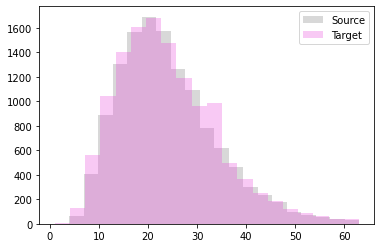

In [106]:
plt.hist(X_sentence_lens, bins=20, alpha=0.3, label='Source')
plt.hist(y_sentence_lens, bins=20, alpha=0.3, label='Target')
plt.legend()
plt.show()

# words didnt't change in 62.04 percent of cases
# +-1 word change in 26.96 percent ofcases
# bigger change in 11.00 percent of cases


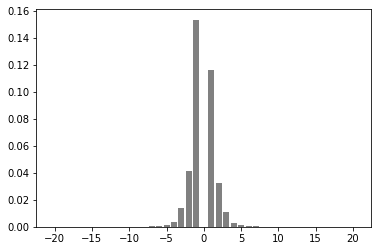

In [107]:
unique, counts = np.unique(len_diffs[len_diffs!=0], return_counts=True)
counts = counts / len_diffs.shape[0]
print("# words didnt't change in %.2f percent of cases" % (100* len_diffs[len_diffs==0].shape[0] / len_diffs.shape[0]))
print("# +-1 word change in %.2f percent ofcases" % (100* len_diffs[abs(len_diffs) == 1].shape[0] / len_diffs.shape[0]))
print("# bigger change in %.2f percent of cases" % (100* len_diffs[abs(len_diffs) > 1].shape[0] / len_diffs.shape[0]))
plt.bar(unique, counts)
plt.show()

In [118]:
data = pd.DataFrame({'source':X, 'target':y})
data.to_csv('realec_data.csv', index=False)

In [109]:
data_final.drop(index = indices_to_drop, inplace=True)
data_final.reset_index(drop=True, inplace=True)
data_final.to_csv('alldata.csv', index=False)

In [110]:
data_final

,sentence_id,error_sentence,corrected_sentence,spans_before,spans_after
0,0,"""agriculture"" in indonesia is in the middle place and the last one is under ""industry"" control.","""agriculture"" in indonesia is in the second place and the last one is under ""industry"" control.","[(37, 43)]","[(37, 43)]"
1,1,"""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","[(144, 165)]","[(144, 162)]"
2,2,(12 million visitors) the second country was spain with 9 million british residents.,(12 million visitors) the second country was spain with 9 million british holiday-makers.,"[(74, 83)]","[(74, 88)]"
3,3,(in 2020 it became 13 percent ).,(in 2020 it will be 13 percent ).,"[(12, 18)]","[(12, 19)]"
4,4,"(the destination between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for ...","(the distance between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for 5 h...","[(5, 16)]","[(5, 13)]"
...,...,...,...,...,...
12706,13429,"which one associated with clearing an economy, growing benefits for dealers and increasing of motivation level among...","that one can include clearing an economy, growing benefits for dealers and increasing of motivation level among musi...","[(10, 25), (0, 5)]","[(10, 21), (0, 4)]"
12707,13430,"which rate was get a high in 2015, with 7,9 percent and become lower in 2014, it is now 7,5 percent .","which rate was get a high in 2015, with 7,9 percent and become lower in 2014, it became 7,5 percent .","[(81, 87)]","[(81, 87)]"
12708,13431,while only 6 percent of the last age group use it.,while only 6 percent of the latter age group use it.,"[(28, 32)]","[(28, 34)]"
12709,13432,"while the market of electronic books will see a slight increase - from 1 billion dollars in 2014 to 1,5 billion doll...","meanwhile the market of electronic books will see a slight increase - from 1 billion dollars in 2014 to 1,5 billion ...","[(0, 5)]","[(0, 9)]"


In [115]:
pairs1 = list(itertools.chain(*pairs))
pairs1 = ((Counter(pairs1).most_common()))
error_corrections, ec_counts = list(zip(*pairs1))
ec_counts = np.array(ec_counts)

# Unique mistakes: 11492
# Mistakes encounetered once: 87.84 percent
# Mistakes encounetered twice: 6.96 percent


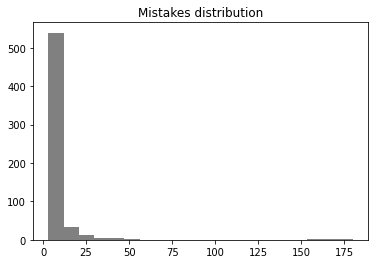

In [116]:
print(f"# Unique mistakes: {len(error_corrections)}")
print(f"# Mistakes encounetered once: {round(100 *np.where(ec_counts == 1)[0].shape[0] / len(ec_counts), 2)} percent")
print(f"# Mistakes encounetered twice: {round(100 *np.where(ec_counts == 2)[0].shape[0] / len(ec_counts), 2)} percent")
plt.hist(ec_counts[ec_counts>2], bins=20)
plt.title('Mistakes distribution')
plt.show()

In [117]:
for er, cor in error_corrections[:15]:
  print(f"{er} >> {cor}")

amount >> number
years >> years old
then >> than
percent >> percentage
quantity >> number
number >> percentage
another >> other
sport >> sports
than >> then
of >> 
which >> that
amount >> numbers
amount >> percentage
different >> various
economical >> economic


# FCE CLC data

In [7]:
#!wget https://github.com/yuagorshkova/realec_lexical_error_correction/blob/main/FCE_texts.zip
#!unzip FCE_texts.zip -d FCE_texts

In [39]:
with open('FCE_texts/fce_source_texts.txt') as f:
  source_texts = f.readlines()
with open('FCE_texts/fce_target_texts.txt') as f:
  target_texts = f.readlines()
print(len(source_texts), len(target_texts))

15987 15987


Исключим ошибки в пунктуации --  в первую очередь в делении на предложения.

In [45]:
_tokenize_fce_line = lambda x: sent_tokenize(x.strip())
def fce_preprocess(source_target_pair):
  source_sents, target_sents = list(map(_tokenize_fce_line, source_target_pair))
  if len(source_sents) == len(target_sents):
    return source_sents, target_sents
  else:
    return [], []

source_sents, target_sents = list(zip(*list(map(fce_preprocess, list(zip(source_texts, target_texts))))))
target_sents = list(itertools.chain(*target_sents))
source_sents = list(itertools.chain(*source_sents))
print(len(source_sents), len(target_sents))

29624 29624


In [46]:
def preprocess_text(text):
  text = text.lower()
  text = text.replace('%', ' percent ')
  text = text.replace('+', ' plus ')
  text = re.sub(r'  +', ' ', text)
  return text

source_sents = list(map(preprocess_text, source_sents))
target_sents = list(map(preprocess_text, target_sents))

In [47]:
token_len = lambda s: len(word_tokenize(s))
source_sents_lens = np.array(list(map(token_len, source_sents)))
target_sents_lens = np.array(list(map(token_len, target_sents)))

thr = 63
n_sent = source_sents_lens.shape[0]
X_n = source_sents_lens[source_sents_lens > thr].shape[0]
y_n = target_sents_lens[target_sents_lens > thr].shape[0]
indices_to_drop = np.union1d(np.where(source_sents_lens > thr)[0], 
                             np.where(target_sents_lens > thr)[0])
together_n = indices_to_drop.shape[0]
print(f"# source sentences longer than {thr} words: {X_n}", " (%.2f percent)"%(100* X_n/n_sent))
print(f"# target sentences longer than {thr} words: {y_n}", " (%.2f percent)"%(100* y_n/n_sent))
print(f"# examples longer than {thr} words: {together_n}", " (%.2f percent)"%(100* together_n/n_sent))

# source sentences longer than 63 words: 27  (0.09 percent)
# target sentences longer than 63 words: 29  (0.10 percent)
# examples longer than 63 words: 31  (0.10 percent)


In [52]:
fce_X = np.delete(source_sents, indices_to_drop)
fce_y = np.delete(target_sents, indices_to_drop)

fce_X.shape, fce_y.shape

((29593,), (29593,))

In [121]:
correct = np.array([fce_X[i] == fce_y[i] for i in range(fce_X.shape[0])])
num_correct = sum(correct)
print(f"Out of {fce_X.shape[0]} sentences {num_correct} are correct ({round(100 * num_correct / fce_X.shape[0], 2)} percent),\
{fce_X.shape[0] - num_correct} contain mistakes ({100 - round(100 * num_correct / fce_X.shape[0], 2)} percent).")

Out of 29593 sentences 12010 are correct (40.58 percent),17583 contain mistakes (59.42 percent).


In [123]:
correct_indices = np.where(correct)[0]
incorrect_indices = np.where(~correct)[0]

data = pd.DataFrame({'source':fce_X[correct_indices], 'target':fce_y[correct_indices]})
data.to_csv('correct_data.csv', index=False)

data = pd.DataFrame({'source':fce_X[incorrect_indices], 'target':fce_y[incorrect_indices]})
data.to_csv('fce_data.csv', index=False)

# Загрузка данных, общая информация о корпусах

In [4]:
!wget https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/realec_data.csv
!wget https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/correct_data.csv
!wget https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/fce_data.csv

--2022-05-26 23:48:19--  https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/realec_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3230746 (3.1M) [text/plain]
Saving to: ‘realec_data.csv.4’

realec_data.csv.4   100%[===================>]   3.08M  --.-KB/s    in 0.07s   

2022-05-26 23:48:19 (44.7 MB/s) - ‘realec_data.csv.4’ saved [3230746/3230746]

--2022-05-26 23:48:19--  https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/correct_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, await

In [5]:
correct_data = pd.read_csv('correct_data.csv')
correct_X, correct_y = correct_data['source'].to_numpy(), correct_data['target'].to_numpy()
print(correct_data.shape)
correct_data.sample(2)

(12010, 2)


,source,target
9474,"i bought a ticket for the ""over the rainbow"" m...","i bought a ticket for the ""over the rainbow"" m..."
4726,what do you think?,what do you think?


In [6]:
realec_data = pd.read_csv('realec_data.csv')
realec_X, realec_y = realec_data['source'].to_numpy(), realec_data['target'].to_numpy()
print(realec_data.shape)
realec_data.sample(2)

(12711, 2)


,source,target
3263,"furthermore, twice shorter lines of paris syst...","furthermore, twice shorter lines of paris syst..."
6417,"moreover, there is no way to overcome internet...","moreover, there is no way to overcome internet..."


In [7]:
fce_data = pd.read_csv('fce_data.csv')
fce_X, fce_y = fce_data['source'].to_numpy(), fce_data['target'].to_numpy()
print(fce_data.shape)
fce_data.sample(2)

(17583, 2)


,source,target
9912,our lessons start at 8 a.m and we aren't allow...,our lessons start at 8 am and we aren't allowe...
16905,i am quite good at singing and i have a talent...,i am quite good at singing and i have a talent...


In [8]:
token_len = lambda s: len(word_tokenize(s))
def get_info(source_sentences, target_sentences):
  source_sents_lens = np.array(list(map(token_len, source_sentences)))
  target_sents_lens = np.array(list(map(token_len, target_sentences)))
  return {'sentence_volume': len(source_sentences), 
          'source_token_volume': sum(source_sents_lens), 
          'target_token_volume': sum(target_sents_lens), 
          'source_avg_sentence_len': np.average(source_sents_lens),
          'target_avg_sentence_len': np.average(target_sents_lens)}


In [9]:
from sklearn.model_selection import train_test_split

def train_test_split_dict(X, y, test_size=0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=1)
  return {'X_train': X_train,
          'X_test': X_test,
          'y_train': y_train,
          'y_test': y_test}

model_data = {
    'realec': train_test_split_dict(realec_X, realec_y),
    'fce': train_test_split_dict(fce_X, fce_y),
    'correct': train_test_split_dict(correct_X, correct_y)
}

In [10]:
info = {}
info['realec_train'] = get_info(model_data['realec']['X_train'], model_data['realec']['y_train'])
info['realec_test'] = get_info(model_data['realec']['X_test'], model_data['realec']['y_test'])
info['fce_train'] = get_info(model_data['fce']['X_train'], model_data['fce']['y_train'])
info['fce_test'] = get_info(model_data['fce']['X_test'], model_data['fce']['y_test'])
info['correct_train'] = get_info(model_data['correct']['X_train'], model_data['correct']['y_train'])
info['correct_test'] = get_info(model_data['correct']['X_test'], model_data['correct']['y_test'])
info = pd.DataFrame(info)
for c in info.columns:
  info[c] = info[c].apply(lambda x: round(x, 2))
info

,realec_train,realec_test,fce_train,fce_test,correct_train,correct_test
sentence_volume,10168.00,2543.00,14066.00,3517.00,9608.00,2402.00
source_token_volume,243605.00,60272.00,259621.00,64223.00,94613.00,23845.00
target_token_volume,244307.00,60400.00,264093.00,65411.00,94613.00,23845.00
source_avg_sentence_len,23.96,23.70,18.46,18.26,9.85,9.93
target_avg_sentence_len,24.03,23.75,18.78,18.60,9.85,9.93


# Архитектура seq2seq


In [11]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [12]:
import os
import numpy as np
import datetime

from collections import Counter

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy

In [13]:
torch.manual_seed(1)
if torch.cuda.is_available():
  print('Using cuda')
  device = torch.device("cuda")
  torch.cuda.manual_seed_all(1)
else:
  print('Using cpu')
  device = torch.device("cpu")

n_gpu = torch.cuda.device_count()
print(torch.__version__)
print(device)

Using cuda
1.11.0+cu113
cuda


## define architecture

#### Dataset + collate fn

In [25]:
class AttrDict(dict):
  """ Access dictionary keys like attributes
      https://stackoverflow.com/questions/4984647/accessing-dict-keys-like-an-attribute
  """
  def __init__(self, *args, **kwargs):
    dict.__init__(self, *args, **kwargs)
    self.__dict__ = self

def log_info(message, type='INFO'):
  print(f"{type}\t{str(datetime.datetime.today()).split('.')[0]}\t{message}")


PAD = 0
BOS = 1
EOS = 2
UNK = 3
PUNCT = 4
NUM = 5
UTILITY_TOKENS = {PAD:'<PAD>', BOS:'<BOS>', EOS:'<EOS>', UNK:'<UNK>', PUNCT:'<PUNCT>', NUM:'<NUM>'}

def token_mapper(token):
  if token.isalpha():
    return token
  elif token.isdigit():
    return "<NUM>"
  else:
    return "<PUNCT>"

class LECDataset(Dataset):
  
  def __init__(self, 
               source,
               target,
               vocab=None, 
               max_vocab_size=50000):
    self.word_tokenizer = word_tokenize
    self.max_vocab_size = max_vocab_size

    log_info('Loading source sentences')
    self.source_sentences = self.word_tokenize_sentences(source)
    log_info('Loading source sentences')
    self.target_sentences = self.word_tokenize_sentences(target)

    if vocab:
      self.vocab = vocab
    else:
      log_info('Building Vocab')
      self.vocab = self.build_vocab(self.source_sentences + self.target_sentences, self.max_vocab_size)
    log_info('\nBuilding dataset complete')

  def __len__(self):
    return len(self.source_sentences)

  def __getitem__(self, index):
    source_sentence = self.source_sentences[index]
    target_sentence = self.target_sentences[index]

    source_sequence = self.tokens2ids(source_sentence, append_EOS=True)
    target_sequence = self.tokens2ids(target_sentence, append_EOS=True)
    return source_sentence, target_sentence, source_sequence, target_sequence

  def _tokenize_sentence(self, sentence):
    return list(map(token_mapper, self.word_tokenizer(sentence.lower())))

  def word_tokenize_sentences(self, data):
    return [self._tokenize_sentence(sentence) for sentence in tqdm(data)]

  def build_vocab(self, corpus, max_vocab_size):
    vocab_counter = Counter()
    for sentence in corpus:
      vocab_counter.update(sentence)
    vocab_counter.pop('<PUNCT>')
    vocab_counter.pop('<NUM>')

    vocab = AttrDict()
    vocab.token2id = {v:k for k, v in UTILITY_TOKENS.items()}
    vocab.token2id.update({token: _id+6 for _id, (token, _) in tqdm(enumerate(vocab_counter.most_common(max_vocab_size)))})
    vocab.id2token = {v:k for k,v in vocab.token2id.items()}
    return vocab

  def tokens2ids(self, tokens, append_BOS=False, append_EOS=True):
    id_sequence = []
    if append_BOS: 
      id_sequence.append(BOS)
    id_sequence.extend([self.vocab.token2id.get(token, UNK) for token in tokens])
    if append_EOS: 
      id_sequence.append(EOS)
    return id_sequence

In [26]:
def collate_fn(data):
  def _pad(seqs):
      lens = [len(seq) for seq in seqs]
      padded_seqs = torch.zeros(len(seqs), max(lens)).long()
      for i, seq in enumerate(seqs):
          end = lens[i]
          padded_seqs[i, :end] = torch.LongTensor(seq[:end])
      return padded_seqs, lens

  data.sort(key=lambda x: len(x[0]), reverse=True)
  source_sentences, target_sentencs, source_sequences, target_sequences = zip(*data)
  
  source_sequences, source_lens = _pad(source_sequences)
  target_sequences, target_lens = _pad(target_sequences)
  
  source_sequences = source_sequences.transpose(0,1)
  target_sequences = target_sequences.transpose(0,1)

  return source_sequences, target_sequences, source_lens, target_lens

#### Define Encoder and Decoder

In [27]:
class EncoderRNN(nn.Module):
  def __init__(self, embedding=None, hidden_size=128, num_layers=1, dropout=0.3):
    super(EncoderRNN, self).__init__()
    
    self.num_layers = num_layers
    self.dropout = dropout
    self.bidirectional = True
    self.num_directions = 2
    self.hidden_size = hidden_size // self.num_directions
    
    self.embedding = embedding
    self.word_vec_size = self.embedding.embedding_dim
    
    self.rnn = nn.LSTM(input_size=self.word_vec_size,
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers,
                        dropout=self.dropout,
                        bidirectional=self.bidirectional)
        
  def forward(self, src_seqs, src_lens, hidden=None):

    embedded = self.embedding(src_seqs)
    packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lens)
    packed_outputs, hidden = self.rnn(packed, hidden)
    outputs, output_lens =  nn.utils.rnn.pad_packed_sequence(packed_outputs)
    if self.bidirectional:
      hidden = self._cat_directions(hidden)
    return outputs, hidden

  def _cat_directions(self, hidden):
    """ https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176 """
    def _cat(h):
      return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
        
    if isinstance(hidden, tuple):
      hidden = tuple([_cat(h) for h in hidden])
    else:
      hidden = _cat(hidden)
    return hidden

In [28]:
def sequence_mask(sequence_length, max_len=None):
  """Input and Return are VARIABLE."""
  if max_len is None:
      max_len = sequence_length.data.max()
  batch_size = sequence_length.size(0)
  seq_range = torch.arange(0, max_len).long()
  seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
  seq_range_expand = Variable(seq_range_expand)
  seq_range_expand = seq_range_expand.to(device)
  seq_length_expand = (sequence_length.unsqueeze(1)
                        .expand_as(seq_range_expand))
  mask = seq_range_expand < seq_length_expand
  return mask

class LuongAttnDecoderRNN(nn.Module):
  def __init__(self, encoder, embedding=None, attention=True, bias=True, tie_embeddings=False, dropout=0.3):
    
    super(LuongAttnDecoderRNN, self).__init__()
    
    self.hidden_size = encoder.hidden_size * encoder.num_directions
    self.num_layers = encoder.num_layers
    self.dropout = dropout
    self.embedding = embedding
    self.attention = attention
    self.tie_embeddings = tie_embeddings
    
    self.vocab_size = self.embedding.num_embeddings
    self.word_vec_size = self.embedding.embedding_dim
    
    self.rnn = nn.LSTM(input_size=self.word_vec_size,
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers,
                        dropout=self.dropout)
    
    if self.attention:
        self.attn = nn.Linear(self.hidden_size,self.hidden_size, bias=bias)
        self.concat = nn.Linear(self.hidden_size * 2, self.hidden_size, bias=bias)
    
    if self.tie_embeddings:
        self.project = nn.Linear(self.hidden_size, self.word_vec_size, bias=bias)
        self.out = nn.Linear(self.word_vec_size, self.vocab_size, bias=bias)
        self.out.weight = self.embedding.weight
    else:
        self.out = nn.Linear(self.hidden_size, self.vocab_size, bias=bias)

  def forward(self, input_seq, decoder_hidden, encoder_outputs, src_lens):     
    input_seq = input_seq.unsqueeze(0)
    
    emb = self.embedding(input_seq)
    decoder_output, decoder_hidden = self.rnn(emb, decoder_hidden)
    decoder_output = decoder_output.transpose(0,1)

    if self.attention:
      attention_scores = torch.bmm(decoder_output, self.attn(encoder_outputs).transpose(0,1).transpose(1,2))

      attention_mask = sequence_mask(src_lens).unsqueeze(1)
      attention_scores.data.masked_fill_(~attention_mask.data, -float('inf'))
      try: # torch 0.3.x
        attention_weights = F.softmax(attention_scores.squeeze(1), dim=1).unsqueeze(1)
      except:
        attention_weights = F.softmax(attention_scores.squeeze(1), dim=1).unsqueeze(1)

      context_vector = torch.bmm(attention_weights, encoder_outputs.transpose(0,1))
      concat_input = torch.cat([context_vector, decoder_output], -1)
      concat_output = torch.tanh(self.concat(concat_input))
      attention_weights = attention_weights.squeeze(1)
    else:
      attention_weights = None
      concat_output = decoder_output

    if self.tie_embeddings:
      output = self.out(self.project(concat_output))
    else:
      output = self.out(concat_output)   

    output = output.squeeze(1)
    del src_lens
    return output, decoder_hidden, attention_weights

#### Define loss function and load pretrained embeddings

In [29]:
def masked_cross_entropy(logits, target, length):
  logits_flat = logits.view(-1, logits.size(-1))
  log_probs_flat = F.log_softmax(logits_flat)
  target_flat = target.view(-1, 1)
  losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
  losses = losses_flat.view(*target.size())
  mask = sequence_mask(sequence_length=length, max_len=target.size(1))
  losses = losses * mask.float()
  loss = losses.sum() / mask.float().sum()
  
  pred_flat = log_probs_flat.max(1)[1]
  pred_seqs = pred_flat.view(*target.size()).transpose(0,1).contiguous()
  mask_flat = mask.view(-1)
  
  # https://discuss.pytorch.org/t/batch-size-and-validation-accuracy/4066/3
  num_corrects = int(pred_flat.eq(target_flat.squeeze(1)).masked_select(mask_flat).float().data.sum())
  num_words = length.data.sum()

  return loss, pred_seqs, num_corrects, num_words

def load_pretrained_embedding(spacy_nlp, vocab):
  vocab_size = len(vocab.token2id)
  word_vec_size = spacy_nlp.vocab.vectors_length
  embedding = np.zeros((vocab_size, word_vec_size))
  unk_count = 0
  
  for token, index in tqdm(vocab.token2id.items()):
    if token == vocab.id2token[PAD]: 
        continue
    elif token in UTILITY_TOKENS: 
        vector = np.random.rand(word_vec_size,)
    elif spacy_nlp.vocab[token].has_vector: 
        vector = spacy_nlp.vocab[token].vector
    else:
        vector = embedding[UNK]  
    embedding[index] = vector
    
  return torch.from_numpy(embedding).float()

#### Checkpoint operations

In [30]:
def load_checkpoint(checkpoint_path):
  # `map_location` loads faster
  return torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

def save_checkpoint(experiment_name, encoder, decoder, encoder_optim, decoder_optim, epoch):
  checkpoint = {
    'epoch': epoch,
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'encoder_optim_state_dict': encoder_optim.state_dict(),
    'decoder_optim_state_dict': decoder_optim.state_dict()}
  
  checkpoint_path = f'checkpoints/{experiment_name}{str(epoch)}.pt'
  directory, filename = os.path.split(os.path.abspath(checkpoint_path))
  if not os.path.exists(directory):
      os.makedirs(directory)
  torch.save(checkpoint, checkpoint_path)
  return checkpoint_path


#### Define Training Step

In [31]:
def detach_hidden(hidden):
  """ Solve memory leak problem """
  if type(hidden) == Variable:
      hidden.detach_() # same as creating a new variable.
  else:
      for h in hidden: h.detach_()

In [32]:
MAX_LEN = 64
def train(src_seqs, tgt_seqs, src_lens, tgt_lens,
          encoder, decoder, encoder_optim, decoder_optim):    
    batch_size = src_seqs.size(1)
    assert(batch_size == tgt_seqs.size(1))
    
    src_seqs = Variable(src_seqs)
    tgt_seqs = Variable(tgt_seqs)
    src_lens = Variable(torch.LongTensor(src_lens))
    tgt_lens = Variable(torch.LongTensor(tgt_lens))

    decoder_input_seq = Variable(torch.LongTensor([BOS] * batch_size))
    decoder_outputs = Variable(torch.zeros(MAX_LEN, batch_size, decoder.vocab_size))


    src_seqs = src_seqs.to(device)
    tgt_seqs = tgt_seqs.to(device)
    src_lens = src_lens.to(device)
    tgt_lens = tgt_lens.to(device)
    decoder_input_seq = decoder_input_seq.to(device)
    decoder_outputs = decoder_outputs.to(device)

    encoder.train()
    decoder.train()
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
        
    encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

    # Initialize decoder's hidden state as encoder's last hidden state.
    decoder_hidden = encoder_hidden
    
    # Run through decoder
    max_tgt_len = tgt_lens.data.max()
    for t in range(max_tgt_len):
      decoder_output, decoder_hidden, attention_weights = decoder(decoder_input_seq, decoder_hidden,
                                                                  encoder_outputs, src_lens)
      decoder_outputs[t] = decoder_output
      decoder_input_seq = tgt_seqs[t]
      detach_hidden(decoder_hidden)
        

    loss, pred_seqs, num_corrects, num_words = masked_cross_entropy(
      decoder_outputs[:max_tgt_len].transpose(0,1).contiguous(), 
      tgt_seqs.transpose(0,1).contiguous(),
      tgt_lens)
    pred_seqs = pred_seqs[:max_tgt_len]

    loss.backward()
    
    # Clip gradients
    encoder_grad_norm = nn.utils.clip_grad_norm_(encoder.parameters(), MAX_GRAD_NORM)
    decoder_grad_norm = nn.utils.clip_grad_norm_(decoder.parameters(), MAX_GRAD_NORM)
    
    # Update parameters with optimizers
    encoder_optim.step()
    decoder_optim.step()
        
    return loss.item(), pred_seqs, attention_weights, num_corrects, num_words,\
           encoder_grad_norm, decoder_grad_norm

#### Define Evaluation process

In [33]:
def evaluate(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder):
  batch_size = src_seqs.size(1)
  assert(batch_size == tgt_seqs.size(1))
  
  src_seqs = Variable(src_seqs, volatile=True)
  tgt_seqs = Variable(tgt_seqs, volatile=True)
  src_lens = Variable(torch.LongTensor(src_lens), volatile=True)
  tgt_lens = Variable(torch.LongTensor(tgt_lens), volatile=True)
  #src_seqs = src_seqs.requires_grad = False
  #tgt_seqs = tgt_seqs.requires_grad = False
  #src_lens = src_lens.requires_grad = False
  #tgt_lens = tgt_lens.requires_grad = False

  decoder_input_seq = Variable(torch.LongTensor([BOS] * batch_size), volatile=True)
  
  max_tgt_len = tgt_lens.data.max()
  decoder_outputs = Variable(torch.zeros(MAX_LEN, batch_size, decoder.vocab_size), volatile=True)

  src_seqs = src_seqs.to(device)
  tgt_seqs = tgt_seqs.to(device)
  src_lens = src_lens.to(device)
  tgt_lens = tgt_lens.to(device)
  decoder_input_seq = decoder_input_seq.to(device)
  decoder_outputs = decoder_outputs.to(device)

  encoder.eval()
  decoder.eval()
          
  encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())
  decoder_hidden = encoder_hidden

  for t in range(max_tgt_len):
    decoder_output, decoder_hidden, attention_weights = decoder(decoder_input_seq, decoder_hidden,
                                                                encoder_outputs, src_lens)
    decoder_outputs[t] = decoder_output
    decoder_input_seq = tgt_seqs[t]
    detach_hidden(decoder_hidden)
      
  loss, pred_seqs, num_corrects, num_words = masked_cross_entropy(
    decoder_outputs[:max_tgt_len].transpose(0,1).contiguous(), 
    tgt_seqs.transpose(0,1).contiguous(),
    tgt_lens)
  
  pred_seqs = pred_seqs[:max_tgt_len]
  
  return loss.item(), pred_seqs, attention_weights, num_corrects, num_words

In [34]:
#EVALUATION
def evaluation(valid_iter, encoder, decoder):
  total_loss, total_corrects, total_words = 0,0,0
  for batch_id, batch_data in enumerate(valid_iter):
    
    src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    
    loss, pred_seqs, attention_weights, num_corrects, num_words \
        = evaluate(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder)
        
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words)
  return total_loss, total_accuracy.item()

#### Plot loss and accuracy

In [35]:
from IPython.display import clear_output
#def plot_journal(train_loss_journal, val_loss_journal,\
#                 train_accuracy_journal, val_accuracy_journal,\
#                 last_save_on_step, checkpoint_path, epoch):
def plot_journal(train_loss_journal, \
                   correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,\
                   train_accuracy_journal,\
                   correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,\
                   last_save_on_step, checkpoint_path, \
                   epoch):
  clear_output()
  train_x = np.arange(PRINT_EVERY_STEP, PRINT_EVERY_STEP * len(train_loss_journal) + 1, PRINT_EVERY_STEP)
  val_x = np.arange(len(correct_val_loss_journal)) #np.arange(EVAL_EVERY_STEP, EVAL_EVERY_STEP * len(val_loss_journal) + 1, EVAL_EVERY_STEP)
  fig, ax = plt.subplots(2, 2, sharex='col', figsize=(18, 10))
  fig.suptitle(f'EPOCH NUMBER {epoch + 1}, global step {GLOBAL_STEP}')

  #if val_x.shape[0] > 0:
  #  ax[0,1].set_xlim([val_x[0] - EVAL_EVERY_STEP// 10, val_x[-1] + EVAL_EVERY_STEP// 10])
  ax[0,0].set(xlabel="global_step")
  ax[0,1].set(xlabel="n_epoch")
  ax[1,0].set(xlabel="global_step")
  ax[1,1].set(xlabel="n_epoch")
  
  #TRAIN LOSS
  ax[0,0].plot(train_x, train_loss_journal, 
               label='train')
  ax[0,0].title.set_text('Train loss')

  #VAL LOSS
  if len(realec_val_loss_journal)>0:
    ax[0,1].plot(val_x[0], realec_val_loss_journal[0])
  ax[0,1].plot(val_x, realec_val_loss_journal, label='realec')
  ax[0,1].plot(val_x, fce_val_loss_journal, label='fce')
  ax[0,1].plot(val_x, correct_val_loss_journal, label='correct')
  ax[0,1].legend()
  ax[0,1].title.set_text('Val loss')

  #TRAIN ACCURACY
  ax[1,0].plot(train_x, train_accuracy_journal, 
               label='train')
  ax[1,0].title.set_text('Train accuracy')

  #VAL ACCURACY
  if len(realec_val_accuracy_journal)>0:
    ax[1,1].plot(val_x[0], realec_val_accuracy_journal[0])
  ax[1,1].plot(val_x, realec_val_accuracy_journal, label='realec')
  ax[1,1].plot(val_x, fce_val_accuracy_journal, label='fce')
  ax[1,1].plot(val_x, correct_val_accuracy_journal, label='correct')
  ax[1,1].legend()
  ax[1,1].title.set_text('Val accuracy')

  print(f"Train loss: {train_loss_journal[-1]}, Train acc: {train_accuracy_journal[-1]}")
  if val_x.shape[0] > 0:
    print(f"REALEC loss: {realec_val_loss_journal[-1]}, acc: {realec_val_accuracy_journal[-1]}")
    print(f"FCE loss: {fce_val_loss_journal[-1]}, acc: {fce_val_accuracy_journal[-1]}")
    print(f"Correct loss: {correct_val_loss_journal[-1]}, acc: {correct_val_accuracy_journal[-1]}")

  
  print(f"last save at step {last_save_on_step}, path: {checkpoint_path}")
  plt.show()

# Experiments

## REALEC

##### Build training dataset and dataloader

In [58]:
#realec, fce, correct
which_dataset = 'realec'
X = model_data[which_dataset]['X_train']
y = model_data[which_dataset]['y_train']

train_dataset = LECDataset(X, y)
src_vocab_size = tgt_vocab_size = len(train_dataset.vocab.token2id)

BATCH_SIZE = 64
train_iter = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:02	Loading source sentences


100%|██████████| 10168/10168 [00:04<00:00, 2340.60it/s]


INFO	2022-05-26 23:55:07	Loading source sentences


100%|██████████| 10168/10168 [00:02<00:00, 3483.72it/s]


INFO	2022-05-26 23:55:10	Building Vocab


7551it [00:00, 1170925.37it/s]

INFO	2022-05-26 23:55:10	
Building dataset complete


##### Evaluation datasets and dataloaders

In [59]:
realec_dataset = LECDataset(model_data['realec']['X_test'], model_data['realec']['y_test'],
                            vocab = train_dataset.vocab)
fce_dataset = LECDataset(model_data['fce']['X_test'], model_data['fce']['y_test'],
                         vocab = train_dataset.vocab)
correct_dataset = LECDataset(model_data['correct']['X_test'], model_data['correct']['y_test'],
                             vocab = train_dataset.vocab)

BATCH_SIZE = 64
realec_iter = DataLoader(dataset=realec_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
fce_iter = DataLoader(dataset=fce_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
correct_iter = DataLoader(dataset=correct_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 5801.50it/s]


INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 4928.69it/s]


INFO	2022-05-26 23:55:11	
Building dataset complete
INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 5833.27it/s]


INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 3999.04it/s]


INFO	2022-05-26 23:55:12	
Building dataset complete
INFO	2022-05-26 23:55:12	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 4717.68it/s]


INFO	2022-05-26 23:55:13	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 3384.72it/s]

INFO	2022-05-26 23:55:13	
Building dataset complete


#### Initialize RNNs + emdeddings + optimizers

In [60]:
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3
TIE_EMBEDDINGS = True
TRAIN_EMBEDDINGS = False
LOAD_CHECKPOINT = False

In [61]:
if LOAD_CHECKPOINT:
  checkpoint_path = './checkpoints/??'
  checkpoint = load_checkpoint(checkpoint_path)
else:
  checkpoint_path = ''

word_vec_size = nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding = nn.Embedding(tgt_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS,
                     dropout=DROPOUT)

decoder = LuongAttnDecoderRNN(encoder, embedding=tgt_embedding,
                              tie_embeddings=TIE_EMBEDDINGS,
                              dropout=DROPOUT)

glove_embeddings = load_pretrained_embedding(nlp, train_dataset.vocab)
encoder.embedding.weight.data.copy_(glove_embeddings)
decoder.embedding.weight.data.copy_(glove_embeddings)

if not TRAIN_EMBEDDINGS:
  encoder.embedding.weight.requires_grad = False
decoder.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
encoder.to(device)
decoder.to(device)

100%|██████████| 7557/7557 [00:00<00:00, 63680.42it/s]


LuongAttnDecoderRNN(
  (embedding): Embedding(7557, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (attn): Linear(in_features=512, out_features=512, bias=True)
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (project): Linear(in_features=512, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=7557, bias=True)
)

In [62]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
MAX_GRAD_NORM = 2
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
decoder_optim = optim.Adam([p for p in decoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

PRINT_EVERY_STEP = 20

GLOBAL_STEP = 0 
last_save_on_step = 0

total_loss = 0
total_corrects = 0
total_words = 0

train_loss_journal, correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal = [], [], [], []
train_accuracy_journal, correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal = [], [], [], []
last_save_on_step = None

def update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal):
  realec_val_loss_journal.append(realec_loss)
  realec_val_accuracy_journal.append(realec_accuracy)
  fce_val_loss_journal.append(fce_loss)
  fce_val_accuracy_journal.append(fce_accuracy)
  correct_val_loss_journal.append(correct_loss)
  correct_val_accuracy_journal.append(correct_accuracy)

#### Train and Visualize

In [64]:
EXPERIMENT_NAME = "realec"
NUM_EPOCHS = 10

Train loss: 17.42803603410721, Train acc: 87.02802276611328
REALEC loss: 47.30324411392212, acc: 84.6781997680664
FCE loss: 119.54555892944336, acc: 74.01781463623047
Correct loss: 43.5877543091774, acc: 81.98270416259766
last save at step 1590, path: checkpoints/realec9.pt


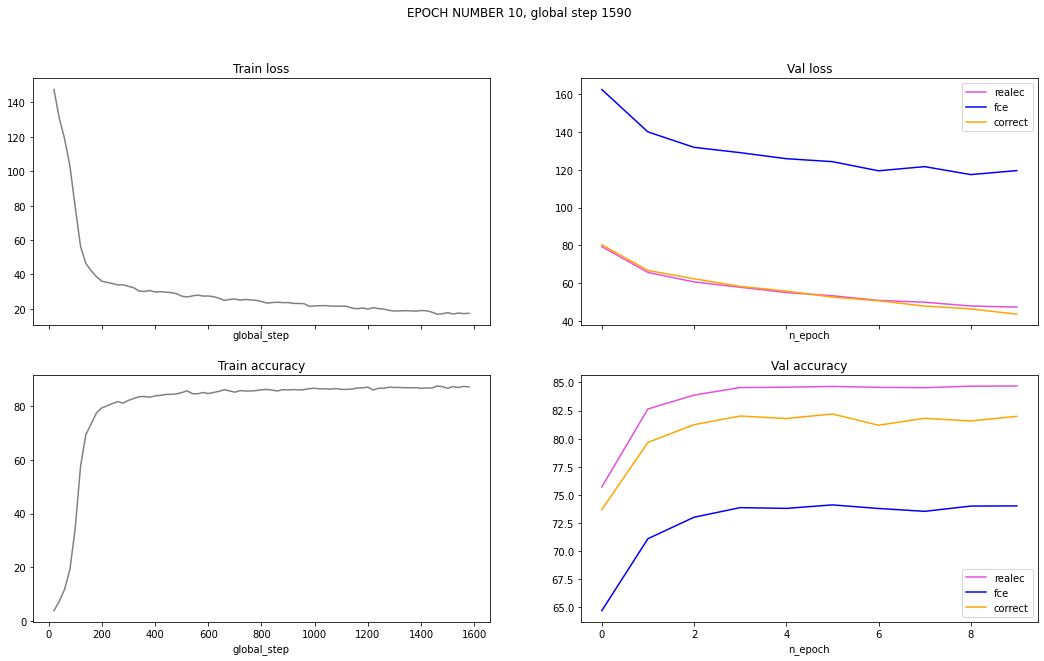

In [65]:
for epoch in range(NUM_EPOCHS):
  for batch_id, batch_data in tqdm(enumerate(train_iter)):

    src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    # Ignore batch if there is a long sequence.
    max_seq_len = max(src_lens + tgt_lens)
    if max_seq_len > MAX_LEN:
      print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(MAX_LEN))
      continue
    
    loss, pred_seqs, attention_weights, num_corrects, num_words, encoder_grad_norm, decoder_grad_norm \
    = train(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder, encoder_optim, decoder_optim)

    # Statistics.
    GLOBAL_STEP += 1
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words)

    if GLOBAL_STEP % PRINT_EVERY_STEP == 0:
      train_loss_journal.append(total_loss)
      train_accuracy_journal.append(total_accuracy.item())
      plot_journal(train_loss_journal, 
                   correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                   train_accuracy_journal,
                   correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                   last_save_on_step = last_save_on_step, 
                   checkpoint_path = checkpoint_path, 
                   epoch = epoch)
      
      total_loss = 0
      total_corrects = 0
      total_words = 0

    del src_seqs, tgt_seqs, src_lens, tgt_lens, \
        loss, pred_seqs, attention_weights, num_corrects, num_words, \
        encoder_grad_norm, decoder_grad_norm

  realec_loss, realec_accuracy = evaluation(realec_iter, encoder, decoder)
  fce_loss, fce_accuracy = evaluation(fce_iter, encoder, decoder)
  correct_loss, correct_accuracy = evaluation(correct_iter, encoder, decoder)
  update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal)

  last_save_on_step = GLOBAL_STEP
  checkpoint_path = save_checkpoint(EXPERIMENT_NAME, encoder, decoder, encoder_optim, decoder_optim, epoch)
  
  print('SAVE'*25)
  print('Save checkpoint to "{}".'.format(checkpoint_path))
  print('SAVE'*25)

  plot_journal(train_loss_journal, 
                correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                train_accuracy_journal,
                correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                last_save_on_step = last_save_on_step, 
                checkpoint_path = checkpoint_path, 
                epoch = epoch)

In [78]:
def str_list(l):
  return list(map(str,l))
def line_to_list(l):
  return list(map(float,l.strip().split('\t')))

with open(f'{EXPERIMENT_NAME}_journal.txt', 'w') as outfile:
  print('='*10+'\n')
  print(EXPERIMENT_NAME+'\n')
  outfile.write(f'train loss every {str(PRINT_EVERY_STEP)} steps, test -- every 1 epoch\n\
  last checpoint saved at {checkpoint_path}\n')
  outfile.write(f'BATCH_SIZE = {str(BATCH_SIZE)}, LEARNING_RATE = {str(LEARNING_RATE)},  WEIGHT_DECAY = {str(WEIGHT_DECAY)}\n')
  outfile.write('train loss\n')
  outfile.write('\t'.join(str_list(train_loss_journal))+'\n')
  outfile.write('train accuracy\n')
  outfile.write('\t'.join(str_list(train_accuracy_journal))+'\n')

  outfile.write('realec val loss\n')
  outfile.write('\t'.join(str_list(realec_val_loss_journal))+'\n')
  outfile.write('realec val accuracy\n')
  outfile.write('\t'.join(str_list(realec_val_accuracy_journal))+'\n')

  outfile.write('fce val loss\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')
  outfile.write('fce val accuracy\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')

  outfile.write('correct val loss\n')
  outfile.write('\t'.join(str_list(correct_val_loss_journal))+'\n')
  outfile.write('correct val accuracy\n')
  outfile.write('\t'.join(str_list(correct_val_accuracy_journal))+'\n')

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.read()
  with open(f'journal.txt', 'a+') as outfile:
    outfile.write(text)

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.readlines()
  print(*text,sep='\n')



realec

train loss every 20 steps, test -- every 1 epoch

  last checpoint saved at checkpoints/realec9.pt

BATCH_SIZE = 64, LEARNING_RATE = 0.001,  WEIGHT_DECAY = 1e-05

train loss

147.47234058380127	130.78260850906372	118.82655477523804	102.94121217727661	79.1634476184845	56.28556442260742	46.362364768981934	42.178693890571594	38.644333839416504	36.08445656299591	35.37387800216675	34.742262840270996	33.92694878578186	34.00762236118317	33.10104298591614	32.23733294010162	30.353287935256958	30.098726272583008	30.70473086833954	29.781200766563416	29.983007073402405	29.718708276748657	29.46478295326233	28.85269272327423	27.404072284698486	26.905128836631775	27.50557041168213	27.992833495140076	27.43727433681488	27.465002059936523	27.082064390182495	26.176954746246338	24.938137412071228	25.440857529640198	25.66706073284149	25.06977117061615	25.471226572990417	25.152732253074646	24.953550100326538	24.28422200679779	23.3385146856308	23.656388998031616	23.85820472240448	23.63000190258026	2

ValueError: ignored

In [ ]:
  train_loss, train_accuracy,\
  realec_loss, realec_accuracy,\
  fce_loss, fce_accuracy,\
  correct_loss,correct_accuracy = list(map(line_to_list, text[5::2]))
  print(f"best train loss: {min(train_loss)}, acc: {max(train_accuracy)} on epoch {np.argmax(train_accuracy)+1}")
  print(f"best realec loss: {min(realec_loss)}, acc: {max(realec_accuracy)}, on epoch {np.argmax(realec_accuracy)+1}")
  print(f"best fce loss: {min(fce_loss)}, acc: {max(fce_accuracy)}, on epoch {np.argmax(fce_accuracy)+1}")
  print(f"best correct loss: {min(correct_loss)}, acc: {max(correct_accuracy)}, on epoch {np.argmax(correct_accuracy)+1}")

## REALEC + Correct

##### Build training dataset and dataloader

In [ ]:
#realec, fce, correct
X = np.append(model_data['realec']['X_train'], model_data['correct']['X_train'])
y = np.append(model_data['realec']['y_train'], model_data['correct']['y_train'])

train_dataset = LECDataset(X, y)
src_vocab_size = tgt_vocab_size = len(train_dataset.vocab.token2id)

BATCH_SIZE = 64
train_iter = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:02	Loading source sentences


100%|██████████| 10168/10168 [00:04<00:00, 2340.60it/s]


INFO	2022-05-26 23:55:07	Loading source sentences


100%|██████████| 10168/10168 [00:02<00:00, 3483.72it/s]


INFO	2022-05-26 23:55:10	Building Vocab


7551it [00:00, 1170925.37it/s]

INFO	2022-05-26 23:55:10	
Building dataset complete


##### Evaluation datasets and dataloaders

In [ ]:
realec_dataset = LECDataset(model_data['realec']['X_test'], model_data['realec']['y_test'],
                            vocab = train_dataset.vocab)
fce_dataset = LECDataset(model_data['fce']['X_test'], model_data['fce']['y_test'],
                         vocab = train_dataset.vocab)
correct_dataset = LECDataset(model_data['correct']['X_test'], model_data['correct']['y_test'],
                             vocab = train_dataset.vocab)

BATCH_SIZE = 64
realec_iter = DataLoader(dataset=realec_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
fce_iter = DataLoader(dataset=fce_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
correct_iter = DataLoader(dataset=correct_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 5801.50it/s]


INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 4928.69it/s]


INFO	2022-05-26 23:55:11	
Building dataset complete
INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 5833.27it/s]


INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 3999.04it/s]


INFO	2022-05-26 23:55:12	
Building dataset complete
INFO	2022-05-26 23:55:12	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 4717.68it/s]


INFO	2022-05-26 23:55:13	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 3384.72it/s]

INFO	2022-05-26 23:55:13	
Building dataset complete


#### Initialize RNNs + emdeddings + optimizers

In [ ]:
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3
TIE_EMBEDDINGS = True
TRAIN_EMBEDDINGS = False
LOAD_CHECKPOINT = False

In [ ]:
if LOAD_CHECKPOINT:
  checkpoint_path = './checkpoints/??'
  checkpoint = load_checkpoint(checkpoint_path)
else:
  checkpoint_path = ''

word_vec_size = nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding = nn.Embedding(tgt_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS,
                     dropout=DROPOUT)

decoder = LuongAttnDecoderRNN(encoder, embedding=tgt_embedding,
                              tie_embeddings=TIE_EMBEDDINGS,
                              dropout=DROPOUT)

glove_embeddings = load_pretrained_embedding(nlp, train_dataset.vocab)
encoder.embedding.weight.data.copy_(glove_embeddings)
decoder.embedding.weight.data.copy_(glove_embeddings)

if not TRAIN_EMBEDDINGS:
  encoder.embedding.weight.requires_grad = False
decoder.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
encoder.to(device)
decoder.to(device)

100%|██████████| 7557/7557 [00:00<00:00, 63680.42it/s]


LuongAttnDecoderRNN(
  (embedding): Embedding(7557, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (attn): Linear(in_features=512, out_features=512, bias=True)
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (project): Linear(in_features=512, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=7557, bias=True)
)

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
MAX_GRAD_NORM = 2
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
decoder_optim = optim.Adam([p for p in decoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

PRINT_EVERY_STEP = 20

GLOBAL_STEP = 0 
last_save_on_step = 0

total_loss = 0
total_corrects = 0
total_words = 0

train_loss_journal, correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal = [], [], [], []
train_accuracy_journal, correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal = [], [], [], []
last_save_on_step = None

def update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal):
  realec_val_loss_journal.append(realec_loss)
  realec_val_accuracy_journal.append(realec_accuracy)
  fce_val_loss_journal.append(fce_loss)
  fce_val_accuracy_journal.append(fce_accuracy)
  correct_val_loss_journal.append(correct_loss)
  correct_val_accuracy_journal.append(correct_accuracy)

#### Train and Visualize

In [ ]:
EXPERIMENT_NAME = "correctrealec"
NUM_EPOCHS = 5

Train loss: 46.362364768981934, Train acc: 69.295654296875
last save at step None, path: 


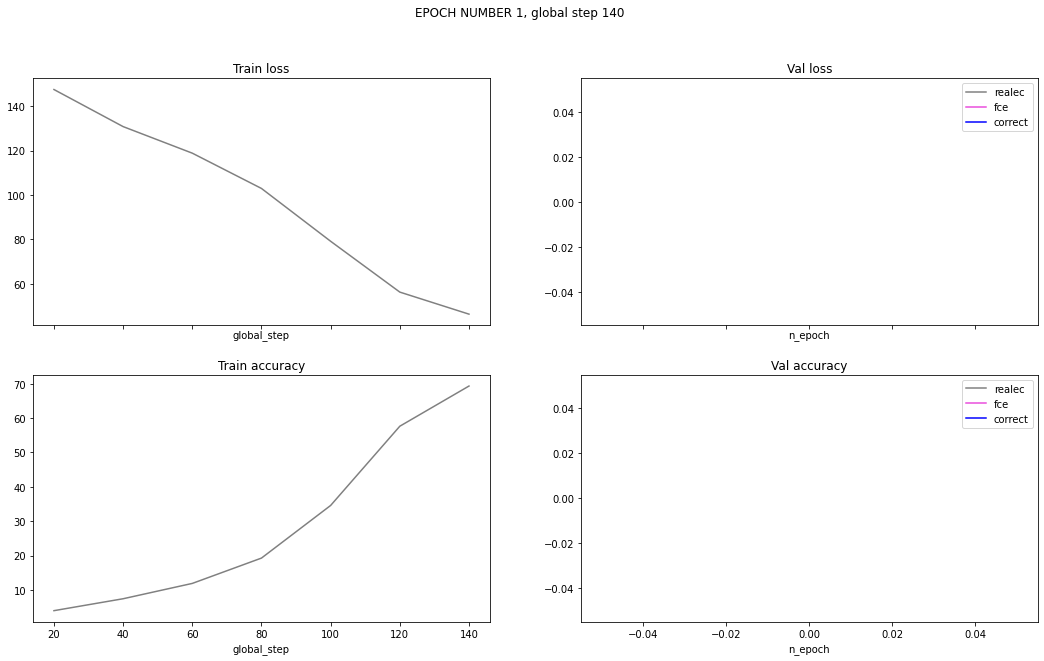

140it [01:16,  1.28it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
159it [01:26,  1.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.

In [ ]:
for epoch in range(NUM_EPOCHS):
  for batch_id, batch_data in tqdm(enumerate(train_iter)):

    src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    # Ignore batch if there is a long sequence.
    max_seq_len = max(src_lens + tgt_lens)
    if max_seq_len > MAX_LEN:
      print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(MAX_LEN))
      continue
    
    loss, pred_seqs, attention_weights, num_corrects, num_words, encoder_grad_norm, decoder_grad_norm \
    = train(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder, encoder_optim, decoder_optim)

    # Statistics.
    GLOBAL_STEP += 1
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words)

    if GLOBAL_STEP % PRINT_EVERY_STEP == 0:
      train_loss_journal.append(total_loss)
      train_accuracy_journal.append(total_accuracy.item())
      plot_journal(train_loss_journal, 
                   correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                   train_accuracy_journal,
                   correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                   last_save_on_step = last_save_on_step, 
                   checkpoint_path = checkpoint_path, 
                   epoch = epoch)
      
      total_loss = 0
      total_corrects = 0
      total_words = 0

    del src_seqs, tgt_seqs, src_lens, tgt_lens, \
        loss, pred_seqs, attention_weights, num_corrects, num_words, \
        encoder_grad_norm, decoder_grad_norm

  realec_loss, realec_accuracy = evaluation(realec_iter, encoder, decoder)
  fce_loss, fce_accuracy = evaluation(fce_iter, encoder, decoder)
  correct_loss, correct_accuracy = evaluation(correct_iter, encoder, decoder)
  update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal)

  last_save_on_step = GLOBAL_STEP
  checkpoint_path = save_checkpoint(EXPERIMENT_NAME, encoder, decoder, encoder_optim, decoder_optim, epoch)
  
  print('SAVE'*25)
  print('Save checkpoint to "{}".'.format(checkpoint_path))
  print('SAVE'*25)

  plot_journal(train_loss_journal, 
                correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                train_accuracy_journal,
                correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                last_save_on_step = last_save_on_step, 
                checkpoint_path = checkpoint_path, 
                epoch = epoch)

In [ ]:
def str_list(l):
  return list(map(str,l))
def line_to_list(l):
  return list(map(float,l.strip().split('\t')))

with open(f'{EXPERIMENT_NAME}_journal.txt', 'w') as outfile:
  print('='*10+'\n')
  print(EXPERIMENT_NAME+'\n')
  outfile.write(f'train loss every {str(PRINT_EVERY_STEP)} steps, test -- every 1 epoch\n\
  last checpoint saved at {checkpoint_path}\n')
  outfile.write(f'BATCH_SIZE = {str(BATCH_SIZE)}, LEARNING_RATE = {str(LEARNING_RATE)},  WEIGHT_DECAY = {str(WEIGHT_DECAY)}\n')
  outfile.write('train loss\n')
  outfile.write('\t'.join(str_list(train_loss_journal))+'\n')
  outfile.write('train accuracy\n')
  outfile.write('\t'.join(str_list(train_accuracy_journal))+'\n')

  outfile.write('realec val loss\n')
  outfile.write('\t'.join(str_list(realec_val_loss_journal))+'\n')
  outfile.write('realec val accuracy\n')
  outfile.write('\t'.join(str_list(realec_val_accuracy_journal))+'\n')

  outfile.write('fce val loss\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')
  outfile.write('fce val accuracy\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')

  outfile.write('correct val loss\n')
  outfile.write('\t'.join(str_list(correct_val_loss_journal))+'\n')
  outfile.write('correct val accuracy\n')
  outfile.write('\t'.join(str_list(correct_val_accuracy_journal))+'\n')

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.read()
  with open(f'journal.txt', 'a+') as outfile:
    outfile.write(text)

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.readlines()
  print(*text,sep='\n')


## FCE + Correct

##### Build training dataset and dataloader

In [ ]:
#realec, fce, correct
X = np.append(model_data['fce']['X_train'], model_data['correct']['X_train'])
y = np.append(model_data['fce']['y_train'], model_data['correct']['y_train'])

train_dataset = LECDataset(X, y)
src_vocab_size = tgt_vocab_size = len(train_dataset.vocab.token2id)

BATCH_SIZE = 64
train_iter = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:02	Loading source sentences


100%|██████████| 10168/10168 [00:04<00:00, 2340.60it/s]


INFO	2022-05-26 23:55:07	Loading source sentences


100%|██████████| 10168/10168 [00:02<00:00, 3483.72it/s]


INFO	2022-05-26 23:55:10	Building Vocab


7551it [00:00, 1170925.37it/s]

INFO	2022-05-26 23:55:10	
Building dataset complete


##### Evaluation datasets and dataloaders

In [ ]:
realec_dataset = LECDataset(model_data['realec']['X_test'], model_data['realec']['y_test'],
                            vocab = train_dataset.vocab)
fce_dataset = LECDataset(model_data['fce']['X_test'], model_data['fce']['y_test'],
                         vocab = train_dataset.vocab)
correct_dataset = LECDataset(model_data['correct']['X_test'], model_data['correct']['y_test'],
                             vocab = train_dataset.vocab)

BATCH_SIZE = 64
realec_iter = DataLoader(dataset=realec_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
fce_iter = DataLoader(dataset=fce_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
correct_iter = DataLoader(dataset=correct_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 5801.50it/s]


INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 4928.69it/s]


INFO	2022-05-26 23:55:11	
Building dataset complete
INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 5833.27it/s]


INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 3999.04it/s]


INFO	2022-05-26 23:55:12	
Building dataset complete
INFO	2022-05-26 23:55:12	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 4717.68it/s]


INFO	2022-05-26 23:55:13	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 3384.72it/s]

INFO	2022-05-26 23:55:13	
Building dataset complete


#### Initialize RNNs + emdeddings + optimizers

In [ ]:
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3
TIE_EMBEDDINGS = True
TRAIN_EMBEDDINGS = False
LOAD_CHECKPOINT = False

In [ ]:
if LOAD_CHECKPOINT:
  checkpoint_path = './checkpoints/??'
  checkpoint = load_checkpoint(checkpoint_path)
else:
  checkpoint_path = ''

word_vec_size = nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding = nn.Embedding(tgt_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS,
                     dropout=DROPOUT)

decoder = LuongAttnDecoderRNN(encoder, embedding=tgt_embedding,
                              tie_embeddings=TIE_EMBEDDINGS,
                              dropout=DROPOUT)

glove_embeddings = load_pretrained_embedding(nlp, train_dataset.vocab)
encoder.embedding.weight.data.copy_(glove_embeddings)
decoder.embedding.weight.data.copy_(glove_embeddings)

if not TRAIN_EMBEDDINGS:
  encoder.embedding.weight.requires_grad = False
decoder.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
encoder.to(device)
decoder.to(device)

100%|██████████| 7557/7557 [00:00<00:00, 63680.42it/s]


LuongAttnDecoderRNN(
  (embedding): Embedding(7557, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (attn): Linear(in_features=512, out_features=512, bias=True)
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (project): Linear(in_features=512, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=7557, bias=True)
)

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
MAX_GRAD_NORM = 2
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
decoder_optim = optim.Adam([p for p in decoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

PRINT_EVERY_STEP = 20

GLOBAL_STEP = 0 
last_save_on_step = 0

total_loss = 0
total_corrects = 0
total_words = 0

train_loss_journal, correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal = [], [], [], []
train_accuracy_journal, correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal = [], [], [], []
last_save_on_step = None

def update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal):
  realec_val_loss_journal.append(realec_loss)
  realec_val_accuracy_journal.append(realec_accuracy)
  fce_val_loss_journal.append(fce_loss)
  fce_val_accuracy_journal.append(fce_accuracy)
  correct_val_loss_journal.append(correct_loss)
  correct_val_accuracy_journal.append(correct_accuracy)

#### Train and Visualize

In [ ]:
EXPERIMENT_NAME = "correctfce"
NUM_EPOCHS = 5

Train loss: 46.362364768981934, Train acc: 69.295654296875
last save at step None, path: 


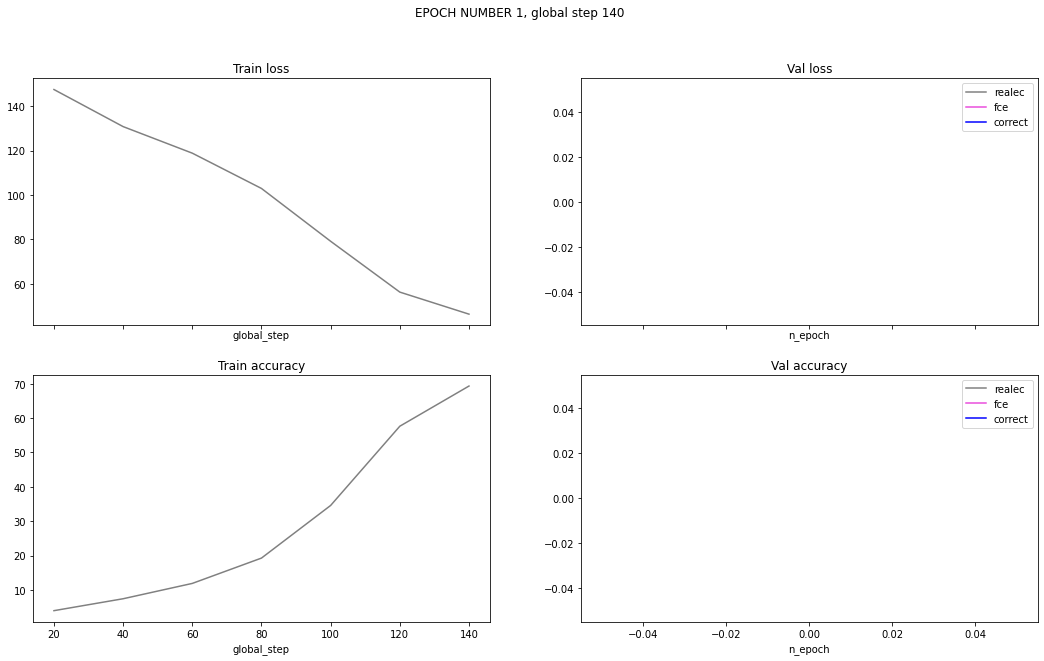

140it [01:16,  1.28it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
159it [01:26,  1.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.

In [ ]:
for epoch in range(NUM_EPOCHS):
  for batch_id, batch_data in tqdm(enumerate(train_iter)):

    src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    # Ignore batch if there is a long sequence.
    max_seq_len = max(src_lens + tgt_lens)
    if max_seq_len > MAX_LEN:
      print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(MAX_LEN))
      continue
    
    loss, pred_seqs, attention_weights, num_corrects, num_words, encoder_grad_norm, decoder_grad_norm \
    = train(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder, encoder_optim, decoder_optim)

    # Statistics.
    GLOBAL_STEP += 1
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words)

    if GLOBAL_STEP % PRINT_EVERY_STEP == 0:
      train_loss_journal.append(total_loss)
      train_accuracy_journal.append(total_accuracy.item())
      plot_journal(train_loss_journal, 
                   correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                   train_accuracy_journal,
                   correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                   last_save_on_step = last_save_on_step, 
                   checkpoint_path = checkpoint_path, 
                   epoch = epoch)
      
      total_loss = 0
      total_corrects = 0
      total_words = 0

    del src_seqs, tgt_seqs, src_lens, tgt_lens, \
        loss, pred_seqs, attention_weights, num_corrects, num_words, \
        encoder_grad_norm, decoder_grad_norm

  realec_loss, realec_accuracy = evaluation(realec_iter, encoder, decoder)
  fce_loss, fce_accuracy = evaluation(fce_iter, encoder, decoder)
  correct_loss, correct_accuracy = evaluation(correct_iter, encoder, decoder)
  update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal)

  last_save_on_step = GLOBAL_STEP
  checkpoint_path = save_checkpoint(EXPERIMENT_NAME, encoder, decoder, encoder_optim, decoder_optim, epoch)
  
  print('SAVE'*25)
  print('Save checkpoint to "{}".'.format(checkpoint_path))
  print('SAVE'*25)

  plot_journal(train_loss_journal, 
                correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                train_accuracy_journal,
                correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                last_save_on_step = last_save_on_step, 
                checkpoint_path = checkpoint_path, 
                epoch = epoch)

In [ ]:
def str_list(l):
  return list(map(str,l))
def line_to_list(l):
  return list(map(float,l.strip().split('\t')))

with open(f'{EXPERIMENT_NAME}_journal.txt', 'w') as outfile:
  print('='*10+'\n')
  print(EXPERIMENT_NAME+'\n')
  outfile.write(f'train loss every {str(PRINT_EVERY_STEP)} steps, test -- every 1 epoch\n\
  last checpoint saved at {checkpoint_path}\n')
  outfile.write(f'BATCH_SIZE = {str(BATCH_SIZE)}, LEARNING_RATE = {str(LEARNING_RATE)},  WEIGHT_DECAY = {str(WEIGHT_DECAY)}\n')
  outfile.write('train loss\n')
  outfile.write('\t'.join(str_list(train_loss_journal))+'\n')
  outfile.write('train accuracy\n')
  outfile.write('\t'.join(str_list(train_accuracy_journal))+'\n')

  outfile.write('realec val loss\n')
  outfile.write('\t'.join(str_list(realec_val_loss_journal))+'\n')
  outfile.write('realec val accuracy\n')
  outfile.write('\t'.join(str_list(realec_val_accuracy_journal))+'\n')

  outfile.write('fce val loss\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')
  outfile.write('fce val accuracy\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')

  outfile.write('correct val loss\n')
  outfile.write('\t'.join(str_list(correct_val_loss_journal))+'\n')
  outfile.write('correct val accuracy\n')
  outfile.write('\t'.join(str_list(correct_val_accuracy_journal))+'\n')

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.read()
  with open(f'journal.txt', 'a+') as outfile:
    outfile.write(text)

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.readlines()
  print(*text,sep='\n')


## REALEC + FCE

##### Build training dataset and dataloader

In [ ]:
#realec, fce, correct

X = np.append(model_data['realec']['X_train'], model_data['fce']['X_train'])
y = np.append(model_data['realec']['y_train'], model_data['fce']['y_train'])

train_dataset = LECDataset(X, y)
src_vocab_size = tgt_vocab_size = len(train_dataset.vocab.token2id)

BATCH_SIZE = 64
train_iter = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:02	Loading source sentences


100%|██████████| 10168/10168 [00:04<00:00, 2340.60it/s]


INFO	2022-05-26 23:55:07	Loading source sentences


100%|██████████| 10168/10168 [00:02<00:00, 3483.72it/s]


INFO	2022-05-26 23:55:10	Building Vocab


7551it [00:00, 1170925.37it/s]

INFO	2022-05-26 23:55:10	
Building dataset complete


##### Evaluation datasets and dataloaders

In [ ]:
realec_dataset = LECDataset(model_data['realec']['X_test'], model_data['realec']['y_test'],
                            vocab = train_dataset.vocab)
fce_dataset = LECDataset(model_data['fce']['X_test'], model_data['fce']['y_test'],
                         vocab = train_dataset.vocab)
correct_dataset = LECDataset(model_data['correct']['X_test'], model_data['correct']['y_test'],
                             vocab = train_dataset.vocab)

BATCH_SIZE = 64
realec_iter = DataLoader(dataset=realec_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
fce_iter = DataLoader(dataset=fce_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
correct_iter = DataLoader(dataset=correct_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 5801.50it/s]


INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 4928.69it/s]


INFO	2022-05-26 23:55:11	
Building dataset complete
INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 5833.27it/s]


INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 3999.04it/s]


INFO	2022-05-26 23:55:12	
Building dataset complete
INFO	2022-05-26 23:55:12	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 4717.68it/s]


INFO	2022-05-26 23:55:13	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 3384.72it/s]

INFO	2022-05-26 23:55:13	
Building dataset complete


#### Initialize RNNs + emdeddings + optimizers

In [ ]:
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3
TIE_EMBEDDINGS = True
TRAIN_EMBEDDINGS = False
LOAD_CHECKPOINT = False

In [ ]:
if LOAD_CHECKPOINT:
  checkpoint_path = './checkpoints/??'
  checkpoint = load_checkpoint(checkpoint_path)
else:
  checkpoint_path = ''

word_vec_size = nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding = nn.Embedding(tgt_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS,
                     dropout=DROPOUT)

decoder = LuongAttnDecoderRNN(encoder, embedding=tgt_embedding,
                              tie_embeddings=TIE_EMBEDDINGS,
                              dropout=DROPOUT)

glove_embeddings = load_pretrained_embedding(nlp, train_dataset.vocab)
encoder.embedding.weight.data.copy_(glove_embeddings)
decoder.embedding.weight.data.copy_(glove_embeddings)

if not TRAIN_EMBEDDINGS:
  encoder.embedding.weight.requires_grad = False
decoder.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
encoder.to(device)
decoder.to(device)

100%|██████████| 7557/7557 [00:00<00:00, 63680.42it/s]


LuongAttnDecoderRNN(
  (embedding): Embedding(7557, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (attn): Linear(in_features=512, out_features=512, bias=True)
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (project): Linear(in_features=512, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=7557, bias=True)
)

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
MAX_GRAD_NORM = 2
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
decoder_optim = optim.Adam([p for p in decoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

PRINT_EVERY_STEP = 20

GLOBAL_STEP = 0 
last_save_on_step = 0

total_loss = 0
total_corrects = 0
total_words = 0

train_loss_journal, correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal = [], [], [], []
train_accuracy_journal, correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal = [], [], [], []
last_save_on_step = None

def update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal):
  realec_val_loss_journal.append(realec_loss)
  realec_val_accuracy_journal.append(realec_accuracy)
  fce_val_loss_journal.append(fce_loss)
  fce_val_accuracy_journal.append(fce_accuracy)
  correct_val_loss_journal.append(correct_loss)
  correct_val_accuracy_journal.append(correct_accuracy)

#### Train and Visualize

In [ ]:
EXPERIMENT_NAME = "fcerealec"
NUM_EPOCHS = 5

Train loss: 46.362364768981934, Train acc: 69.295654296875
last save at step None, path: 


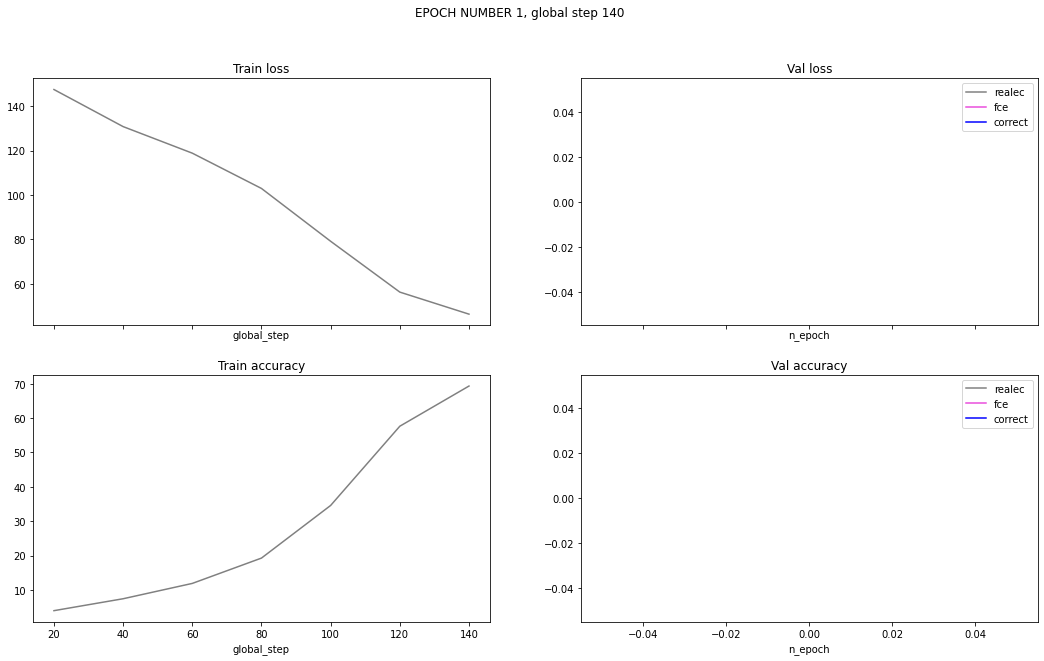

140it [01:16,  1.28it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
159it [01:26,  1.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.

In [ ]:
for epoch in range(NUM_EPOCHS):
  for batch_id, batch_data in tqdm(enumerate(train_iter)):

    src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    # Ignore batch if there is a long sequence.
    max_seq_len = max(src_lens + tgt_lens)
    if max_seq_len > MAX_LEN:
      print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(MAX_LEN))
      continue
    
    loss, pred_seqs, attention_weights, num_corrects, num_words, encoder_grad_norm, decoder_grad_norm \
    = train(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder, encoder_optim, decoder_optim)

    # Statistics.
    GLOBAL_STEP += 1
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words)

    if GLOBAL_STEP % PRINT_EVERY_STEP == 0:
      train_loss_journal.append(total_loss)
      train_accuracy_journal.append(total_accuracy.item())
      plot_journal(train_loss_journal, 
                   correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                   train_accuracy_journal,
                   correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                   last_save_on_step = last_save_on_step, 
                   checkpoint_path = checkpoint_path, 
                   epoch = epoch)
      
      total_loss = 0
      total_corrects = 0
      total_words = 0

    del src_seqs, tgt_seqs, src_lens, tgt_lens, \
        loss, pred_seqs, attention_weights, num_corrects, num_words, \
        encoder_grad_norm, decoder_grad_norm

  realec_loss, realec_accuracy = evaluation(realec_iter, encoder, decoder)
  fce_loss, fce_accuracy = evaluation(fce_iter, encoder, decoder)
  correct_loss, correct_accuracy = evaluation(correct_iter, encoder, decoder)
  update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal)

  last_save_on_step = GLOBAL_STEP
  checkpoint_path = save_checkpoint(EXPERIMENT_NAME, encoder, decoder, encoder_optim, decoder_optim, epoch)
  
  print('SAVE'*25)
  print('Save checkpoint to "{}".'.format(checkpoint_path))
  print('SAVE'*25)

  plot_journal(train_loss_journal, 
                correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                train_accuracy_journal,
                correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                last_save_on_step = last_save_on_step, 
                checkpoint_path = checkpoint_path, 
                epoch = epoch)

In [ ]:
def str_list(l):
  return list(map(str,l))
def line_to_list(l):
  return list(map(float,l.strip().split('\t')))

with open(f'{EXPERIMENT_NAME}_journal.txt', 'w') as outfile:
  print('='*10+'\n')
  print(EXPERIMENT_NAME+'\n')
  outfile.write(f'train loss every {str(PRINT_EVERY_STEP)} steps, test -- every 1 epoch\n\
  last checpoint saved at {checkpoint_path}\n')
  outfile.write(f'BATCH_SIZE = {str(BATCH_SIZE)}, LEARNING_RATE = {str(LEARNING_RATE)},  WEIGHT_DECAY = {str(WEIGHT_DECAY)}\n')
  outfile.write('train loss\n')
  outfile.write('\t'.join(str_list(train_loss_journal))+'\n')
  outfile.write('train accuracy\n')
  outfile.write('\t'.join(str_list(train_accuracy_journal))+'\n')

  outfile.write('realec val loss\n')
  outfile.write('\t'.join(str_list(realec_val_loss_journal))+'\n')
  outfile.write('realec val accuracy\n')
  outfile.write('\t'.join(str_list(realec_val_accuracy_journal))+'\n')

  outfile.write('fce val loss\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')
  outfile.write('fce val accuracy\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')

  outfile.write('correct val loss\n')
  outfile.write('\t'.join(str_list(correct_val_loss_journal))+'\n')
  outfile.write('correct val accuracy\n')
  outfile.write('\t'.join(str_list(correct_val_accuracy_journal))+'\n')

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.read()
  with open(f'journal.txt', 'a+') as outfile:
    outfile.write(text)

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.readlines()
  print(*text,sep='\n')


## REALEC + FCE + Correct

##### Build training dataset and dataloader

In [ ]:
#realec, fce, correct
X = np.append(model_data['realec']['X_train'], model_data['correct']['X_train'])
X = np.append(X, model_data['fce']['X_train'])
y = np.append(model_data['realec']['y_train'], model_data['correct']['y_train'])
y = np.append(y, model_data['fce']['y_train'])

train_dataset = LECDataset(X, y)
src_vocab_size = tgt_vocab_size = len(train_dataset.vocab.token2id)

BATCH_SIZE = 64
train_iter = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:02	Loading source sentences


100%|██████████| 10168/10168 [00:04<00:00, 2340.60it/s]


INFO	2022-05-26 23:55:07	Loading source sentences


100%|██████████| 10168/10168 [00:02<00:00, 3483.72it/s]


INFO	2022-05-26 23:55:10	Building Vocab


7551it [00:00, 1170925.37it/s]

INFO	2022-05-26 23:55:10	
Building dataset complete


##### Evaluation datasets and dataloaders

In [ ]:
realec_dataset = LECDataset(model_data['realec']['X_test'], model_data['realec']['y_test'],
                            vocab = train_dataset.vocab)
fce_dataset = LECDataset(model_data['fce']['X_test'], model_data['fce']['y_test'],
                         vocab = train_dataset.vocab)
correct_dataset = LECDataset(model_data['correct']['X_test'], model_data['correct']['y_test'],
                             vocab = train_dataset.vocab)

BATCH_SIZE = 64
realec_iter = DataLoader(dataset=realec_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
fce_iter = DataLoader(dataset=fce_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)
correct_iter = DataLoader(dataset=correct_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 5801.50it/s]


INFO	2022-05-26 23:55:10	Loading source sentences


100%|██████████| 2543/2543 [00:00<00:00, 4928.69it/s]


INFO	2022-05-26 23:55:11	
Building dataset complete
INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 5833.27it/s]


INFO	2022-05-26 23:55:11	Loading source sentences


100%|██████████| 3517/3517 [00:00<00:00, 3999.04it/s]


INFO	2022-05-26 23:55:12	
Building dataset complete
INFO	2022-05-26 23:55:12	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 4717.68it/s]


INFO	2022-05-26 23:55:13	Loading source sentences


100%|██████████| 2402/2402 [00:00<00:00, 3384.72it/s]

INFO	2022-05-26 23:55:13	
Building dataset complete


#### Initialize RNNs + emdeddings + optimizers

In [ ]:
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3
TIE_EMBEDDINGS = True
TRAIN_EMBEDDINGS = False
LOAD_CHECKPOINT = False

In [ ]:
if LOAD_CHECKPOINT:
  checkpoint_path = './checkpoints/??'
  checkpoint = load_checkpoint(checkpoint_path)
else:
  checkpoint_path = ''

word_vec_size = nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding = nn.Embedding(tgt_vocab_size, word_vec_size, padding_idx=PAD)
tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS,
                     dropout=DROPOUT)

decoder = LuongAttnDecoderRNN(encoder, embedding=tgt_embedding,
                              tie_embeddings=TIE_EMBEDDINGS,
                              dropout=DROPOUT)

glove_embeddings = load_pretrained_embedding(nlp, train_dataset.vocab)
encoder.embedding.weight.data.copy_(glove_embeddings)
decoder.embedding.weight.data.copy_(glove_embeddings)

if not TRAIN_EMBEDDINGS:
  encoder.embedding.weight.requires_grad = False
decoder.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
encoder.to(device)
decoder.to(device)

100%|██████████| 7557/7557 [00:00<00:00, 63680.42it/s]


LuongAttnDecoderRNN(
  (embedding): Embedding(7557, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (attn): Linear(in_features=512, out_features=512, bias=True)
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (project): Linear(in_features=512, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=7557, bias=True)
)

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
MAX_GRAD_NORM = 2
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
decoder_optim = optim.Adam([p for p in decoder.parameters() if p.requires_grad], 
                           lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

PRINT_EVERY_STEP = 20

GLOBAL_STEP = 0 
last_save_on_step = 0

total_loss = 0
total_corrects = 0
total_words = 0

train_loss_journal, correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal = [], [], [], []
train_accuracy_journal, correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal = [], [], [], []
last_save_on_step = None

def update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal):
  realec_val_loss_journal.append(realec_loss)
  realec_val_accuracy_journal.append(realec_accuracy)
  fce_val_loss_journal.append(fce_loss)
  fce_val_accuracy_journal.append(fce_accuracy)
  correct_val_loss_journal.append(correct_loss)
  correct_val_accuracy_journal.append(correct_accuracy)

#### Train and Visualize

In [ ]:
EXPERIMENT_NAME = "alltogether"
NUM_EPOCHS = 5

Train loss: 46.362364768981934, Train acc: 69.295654296875
last save at step None, path: 


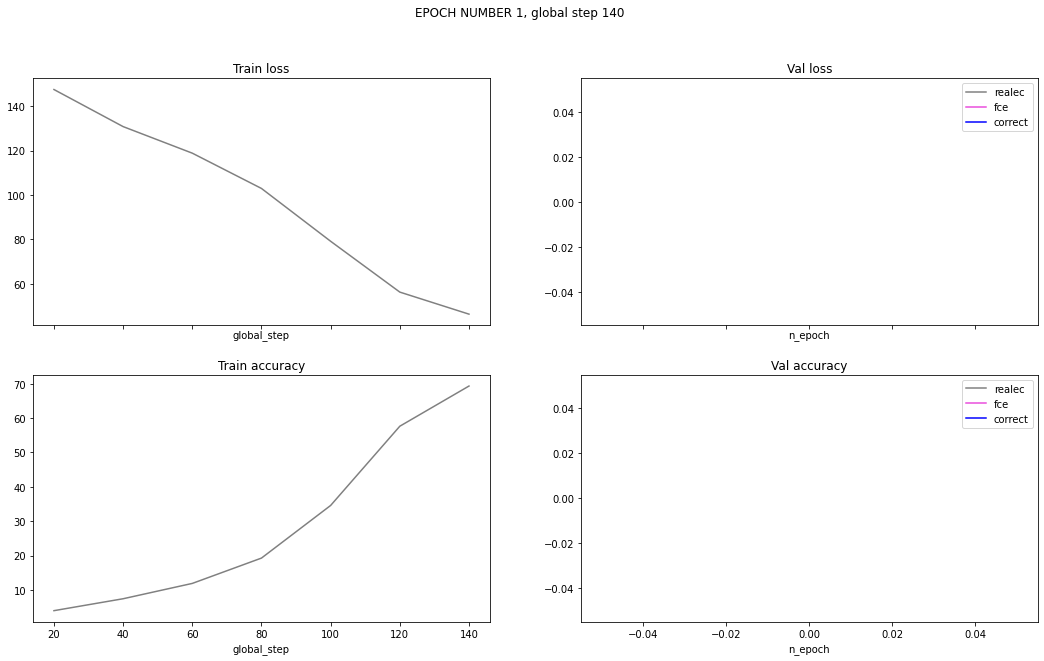

140it [01:16,  1.28it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
159it [01:26,  1.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.

In [ ]:
for epoch in range(NUM_EPOCHS):
  for batch_id, batch_data in tqdm(enumerate(train_iter)):

    src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    # Ignore batch if there is a long sequence.
    max_seq_len = max(src_lens + tgt_lens)
    if max_seq_len > MAX_LEN:
      print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(MAX_LEN))
      continue
    
    loss, pred_seqs, attention_weights, num_corrects, num_words, encoder_grad_norm, decoder_grad_norm \
    = train(src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder, encoder_optim, decoder_optim)

    # Statistics.
    GLOBAL_STEP += 1
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words)

    if GLOBAL_STEP % PRINT_EVERY_STEP == 0:
      train_loss_journal.append(total_loss)
      train_accuracy_journal.append(total_accuracy.item())
      plot_journal(train_loss_journal, 
                   correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                   train_accuracy_journal,
                   correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                   last_save_on_step = last_save_on_step, 
                   checkpoint_path = checkpoint_path, 
                   epoch = epoch)
      
      total_loss = 0
      total_corrects = 0
      total_words = 0

    del src_seqs, tgt_seqs, src_lens, tgt_lens, \
        loss, pred_seqs, attention_weights, num_corrects, num_words, \
        encoder_grad_norm, decoder_grad_norm

  realec_loss, realec_accuracy = evaluation(realec_iter, encoder, decoder)
  fce_loss, fce_accuracy = evaluation(fce_iter, encoder, decoder)
  correct_loss, correct_accuracy = evaluation(correct_iter, encoder, decoder)
  update_journals(realec_loss, realec_accuracy, realec_val_loss_journal, realec_val_accuracy_journal,
                      fce_loss, fce_accuracy, fce_val_loss_journal, fce_val_accuracy_journal,
                      correct_loss, correct_accuracy, correct_val_loss_journal, correct_val_accuracy_journal)

  last_save_on_step = GLOBAL_STEP
  checkpoint_path = save_checkpoint(EXPERIMENT_NAME, encoder, decoder, encoder_optim, decoder_optim, epoch)
  
  print('SAVE'*25)
  print('Save checkpoint to "{}".'.format(checkpoint_path))
  print('SAVE'*25)

  plot_journal(train_loss_journal, 
                correct_val_loss_journal, fce_val_loss_journal, realec_val_loss_journal,
                train_accuracy_journal,
                correct_val_accuracy_journal, fce_val_accuracy_journal, realec_val_accuracy_journal,
                last_save_on_step = last_save_on_step, 
                checkpoint_path = checkpoint_path, 
                epoch = epoch)

In [ ]:
def str_list(l):
  return list(map(str,l))
def line_to_list(l):
  return list(map(float,l.strip().split('\t')))

with open(f'{EXPERIMENT_NAME}_journal.txt', 'w') as outfile:
  print('='*10+'\n')
  print(EXPERIMENT_NAME+'\n')
  outfile.write(f'train loss every {str(PRINT_EVERY_STEP)} steps, test -- every 1 epoch\n\
  last checpoint saved at {checkpoint_path}\n')
  outfile.write(f'BATCH_SIZE = {str(BATCH_SIZE)}, LEARNING_RATE = {str(LEARNING_RATE)},  WEIGHT_DECAY = {str(WEIGHT_DECAY)}\n')
  outfile.write('train loss\n')
  outfile.write('\t'.join(str_list(train_loss_journal))+'\n')
  outfile.write('train accuracy\n')
  outfile.write('\t'.join(str_list(train_accuracy_journal))+'\n')

  outfile.write('realec val loss\n')
  outfile.write('\t'.join(str_list(realec_val_loss_journal))+'\n')
  outfile.write('realec val accuracy\n')
  outfile.write('\t'.join(str_list(realec_val_accuracy_journal))+'\n')

  outfile.write('fce val loss\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')
  outfile.write('fce val accuracy\n')
  outfile.write('\t'.join(str_list(fce_val_accuracy_journal))+'\n')

  outfile.write('correct val loss\n')
  outfile.write('\t'.join(str_list(correct_val_loss_journal))+'\n')
  outfile.write('correct val accuracy\n')
  outfile.write('\t'.join(str_list(correct_val_accuracy_journal))+'\n')

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.read()
  with open(f'journal.txt', 'a+') as outfile:
    outfile.write(text)

with open(f'{EXPERIMENT_NAME}_journal.txt') as infile:
  text = infile.readlines()
  print(*text,sep='\n')
